In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from tqdm import tqdm

from keybert import KeyBERT

import re

from wordcloud import WordCloud
from collections import defaultdict # 데이터프레임 만들때, 딕셔너리형 만들때 사용
import ast # 워드클라우드 전처리에 사용
from sklearn.feature_extraction.text import TfidfVectorizer # idf제

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

# # pd.set_option('display.max_rows', 999)  # 모든 행 출력
# # pd.set_option('display.max_columns', 999)  # 모든 열 출력

c:\Users\new01\miniconda3\envs\ds\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# 자료 불러오기 및 생성

In [2]:
# 기존 자료 + 토론자료 합본 생성 및 저장

# df_speech = pd.read_csv(r"E:\est\kdt\project\president_prediction\data\speech_combined.csv", index_col=0)
# df_debate = pd.read_csv(r"E:\est\kdt\project\president_prediction\data\debate_combined_ver1.csv", index_col=0)

# df_list = [df_speech, df_debate]
# total_speech = pd.concat(df_list, axis=0)
# total_speech = total_speech.reset_index(drop=True)
# total_speech.to_csv(r"E:\est\kdt\project\president_prediction\data\debate_combined_ver2.csv")

In [3]:
total_speech = pd.read_csv(r"E:\est\kdt\project\president_prediction\data\debate_combined_ver2.csv", index_col=0)
total_speech.tail(2)

,name,date,speech,elected,Year,speech_whole,speech_processed,speech_processed2
3395,Donald J. Trump,"October 22, 2020","[""So, as you know, more 2.2 million people, mo...",1,2020,"So, as you know, more 2.2 million people, mode...","['know', '2', '2', 'million', 'people', 'model...","['2', '2', 'million', 'modeled', 'expected', '..."
3396,Donald J. Trump,"September 29, 2020","['How are you doing?', ""Thank you very much, C...",1,2020,"How are you doing? Thank you very much, Chris....","['thank', 'much', 'chris', 'tell', 'simply', '...","['thank', 'much', 'chris', 'tell', 'simply', '..."


In [4]:
# 합본자료 -> KeyBERT 분석한 자료

df_bert = pd.read_csv(r"E:\est\kdt\project\president_prediction\data\KeyBERT_analysis\text_combined.csv", index_col=0)
df_bert.tail(2)

,name,date,speech,elected,Year,speech_whole,speech_processed,speech_processed2,keywords,speech_year
3395,Donald J. Trump,"October 22, 2020","[""So, as you know, more 2.2 million people, mo...",1,2020,"So, as you know, more 2.2 million people, mode...","['know', '2', '2', 'million', 'people', 'model...","['2', '2', 'million', 'modeled', 'expected', '...","[('vaccine coming', 0.5374), ('worldwide pande...",2020
3396,Donald J. Trump,"September 29, 2020","['How are you doing?', ""Thank you very much, C...",1,2020,"How are you doing? Thank you very much, Chris....","['thank', 'much', 'chris', 'tell', 'simply', '...","['thank', 'much', 'chris', 'tell', 'simply', '...","[('phenomenal nominee', 0.4031), ('dame highly...",2020


In [5]:
# 2024년 토론을 KeyBERT 분석한 자료

df_bert_2024 = pd.read_csv(r"E:\est\kdt\project\president_prediction\data\KeyBERT_analysis\2024_combined_v2.csv", index_col=0)
df_bert_2024.tail(2)

,date,speech,name,Year,elected,joined_speech,speech_whole,speech_processed,speech_processed2,keywords,speech_year
2,"January 07, 2021",['I would like to begin by addressing the hein...,Donald J. Trump,2024,0.0,I would like to begin by addressing the heinou...,I would like to begin by addressing the heinou...,"['would', 'like', 'begin', 'addressing', 'hein...","['begin', 'addressing', 'heinous', 'attack', '...","[('elections congress', 0.4297), ('intense ele...",2021
3,"January 23, 2024","['[Music: Lee Greenwood, God Bless the U.S.A.]...",Donald J. Trump,2024,0.0,"[Music: Lee Greenwood, God Bless the U.S.A.] D...","[Music: Lee Greenwood, God Bless the U.S.A.] D...","['donald', 'j', 'trump', 'thank', 'everybody',...","['donald', 'j', 'trump', 'everybody', 'whoa', ...","[('victory speech', 0.4876), ('applause trump'...",2024


In [6]:
# 정형데이터 최종 합본

df_data = pd.read_csv(r"E:\est\kdt\project\president_prediction\data\merged_Data_final_2024GDP.csv")
df_data

,Year,Approval_Rating,CPI,GDP,Unemployment rate,Name,Party,Elections_Won
0,1913,50.000000,9.883333,733625,4.4,NaN,NaN,NaN
1,1914,50.000000,10.016667,677455,8.0,NaN,NaN,NaN
2,1915,50.000000,10.108333,695924,9.7,NaN,NaN,NaN
3,1916,50.000000,10.883333,792425,4.8,Woodrow Wilson,Democratic,2.0
4,1917,50.000000,12.825000,772825,4.8,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
107,2020,41.100000,258.811167,20234100,8.1,Joe Biden,Democratic,1.0
108,2021,41.100000,270.969750,21407700,5.3,NaN,NaN,NaN
109,2022,41.354119,292.654917,21822000,3.6,NaN,NaN,NaN
110,2023,40.184738,304.701583,22376900,NaN,NaN,NaN,NaN


### 데이터 병합

In [ ]:
df_1 = total_speech.copy() # 텍스트 데이터
df_2 = df_data.copy() # 정형 데이터

df_2.drop(111, axis=0, inplace=True) # 2024년 데이터 드랍....

# 정형데이터 4년 단위로 변신
years_to_keep = list(range(1916, 2025, 4))
df_2 = df_2[df_2['Year'].isin(years_to_keep)]

# 병합을 위한 신규 컬럼 생성 - 텍스트 데이터
last_name =[] # 리스트로 데이터 만들고 컬럼에 값으로 채우기
for sen in df_1['name']:
    lname = sen.split()[-1]
    last_name.append(lname)
df_1['LastName'] = last_name # 데이터 채우기

# 병합을 위한 신규 컬럼 생성 - 정형 데이터
last_name =[] # 리스트로 데이터 만들고 컬럼에 값으로 채우기
for sen in df_2['Name']:
    lname = sen.split()[-1]
    last_name.append(lname)
df_2['LastName'] = last_name # 데이터 채우기

merge_data = pd.merge(df_1, df_2, on=['LastName', 'Year'], how='left')
merge_data.head(2)

In [9]:
# Party 채우기

sorted_data = merge_data.sort_values(by='Year')
filled_party = sorted_data[sorted_data['Party'].notnull()]

time_win_party = {}
for time in range(1916, 2024, 4):
    win_party = filled_party[filled_party['Year'] ==time]['Party'].values[0]
    if win_party == 'Republican':
        time_win_party[time] = 'Democratic'
    elif win_party =='Democratic':
        time_win_party[time] = 'Republican'

for idx, row in merge_data.iterrows():
    if pd.isnull(row['Party']):
        nan_year = row['Year']
        merge_data.loc[idx, 'Party'] = time_win_party[nan_year]

merge_data['Party'].isnull().sum() # 혹시 결측 있나 확인 0 이면 정상

0

- Elections_Won 결측 채우기<br>

In [11]:
# 역시 left조인으로 잘 알맞게 달라 붙은 것 같다. -> 결측치는 모두 당선 한번도 안된사람인것을 알 수 있다.
merge_data[merge_data['Name'] =='Dwight D. Eisenhower'] # 여기서 컬럼을 이름만 바꿔서하면 안되는 이유 나옴. name으로는 검색안됨. 신규 컬럼 만들었어야함
merge_data['Elections_Won'].fillna(0, inplace=True)

In [12]:
# 최종으로 만들었던 컬럼 제거

merge_data.drop(['Name','LastName'], axis=1, inplace=True)
merge_data.head()

,name,date,speech,elected,Year,speech_whole,speech_processed,speech_processed2,Approval_Rating,CPI,GDP,Unemployment rate,Party,Elections_Won
0,Charles E. Hughes,"June 10, 1916","['Mr. Chairman and Delegates:', 'I have not de...",0,1916,Mr. Chairman and Delegates: I have not desired...,"['mr', 'chairman', 'delegates', 'desired', 'no...","['mr', 'chairman', 'delegates', 'desired', 'no...",NaN,NaN,NaN,NaN,Republican,0.0
1,Woodrow Wilson,"September 02, 1916","['Senator James, Gentlemen of the Notification...",1,1916,"Senator James, Gentlemen of the Notification C...","['senator', 'james', 'gentlemen', 'notificatio...","['senator', 'james', 'gentlemen', 'notificatio...",50.0,10.883333,792425.0,4.8,Democratic,2.0
2,James M. Cox,"August 07, 1920","['Chairman Robinson, and members of the Notifi...",0,1920,"Chairman Robinson, and members of the Notifica...","['chairman', 'robinson', 'members', 'notificat...","['chairman', 'robinson', 'members', 'notificat...",NaN,NaN,NaN,NaN,Democratic,0.0
3,Warren G. Harding,"July 22, 1920","['Chairman Lodge, Members of the Notification ...",1,1920,"Chairman Lodge, Members of the Notification Co...","['chairman', 'lodge', 'members', 'notification...","['chairman', 'lodge', 'members', 'notification...",50.0,20.041667,841350.0,4.0,Republican,1.0
4,Calvin Coolidge,"August 14, 1924","['Mr. Chairman, Members of the Committee, Ladi...",1,1924,"Mr. Chairman, Members of the Committee, Ladies...","['mr', 'chairman', 'members', 'committee', 'la...","['mr', 'chairman', 'members', 'committee', 'la...",55.0,17.125000,1012202.0,5.5,Republican,1.0


# 데이터 전처리

In [13]:
merge_data.isnull().sum()[merge_data.isnull().sum() != 0]

Approval_Rating      1371
CPI                  1371
GDP                  1371
Unemployment rate    1371
dtype: int64

In [14]:
df_anal = merge_data.copy()
df_anal.drop(['Approval_Rating','CPI','GDP','Unemployment rate','speech'], axis=1, inplace=True)

for idx, row in df_anal.iterrows():
    df_anal.loc[idx, 'name'] = row['name'].strip()
    df_anal.loc[idx, 'Party'] = row['Party'].strip()

# df_anal['Year'] = pd.to_datetime(df_anal['Year']) # 년도는 그냥 두는게 나을지도?
df_anal['date'] = pd.to_datetime(df_anal['date'], format='%B %d, %Y')
df_anal['Party'] = df_anal['Party'].astype('category')
df_anal['name'] = df_anal['name'].astype('category')
df_anal['elected'] = df_anal['elected'].astype('float64')

df_anal.info()
df_anal.tail(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3397 entries, 0 to 3396
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               3397 non-null   category      
 1   date               3397 non-null   datetime64[ns]
 2   elected            3397 non-null   float64       
 3   Year               3397 non-null   int64         
 4   speech_whole       3397 non-null   object        
 5   speech_processed   3397 non-null   object        
 6   speech_processed2  3397 non-null   object        
 7   Party              3397 non-null   category      
 8   Elections_Won      3397 non-null   float64       
dtypes: category(2), datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 194.0+ KB


,name,date,elected,Year,speech_whole,speech_processed,speech_processed2,Party,Elections_Won
3394,Joseph R. Biden,2020-09-29,1.0,2020,"How you doing, man? I'm well. Well, first of a...","['man', 'im', 'well', 'well', 'first', 'thank'...","['man', 'im', 'thank', 'looking', 'forward', '...",Democratic,1.0
3395,Donald J. Trump,2020-10-22,1.0,2020,"So, as you know, more 2.2 million people, mode...","['know', '2', '2', 'million', 'people', 'model...","['2', '2', 'million', 'modeled', 'expected', '...",Republican,0.0
3396,Donald J. Trump,2020-09-29,1.0,2020,"How are you doing? Thank you very much, Chris....","['thank', 'much', 'chris', 'tell', 'simply', '...","['thank', 'much', 'chris', 'tell', 'simply', '...",Republican,0.0


In [38]:
# df_anal IDF 낮은 값 제거 과정

# TF-IDF 벡터화기 생성
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_anal['speech_whole'])

# 단어와 IDF 값 추출
idf_values = vectorizer.idf_
word_to_idf = dict(zip(vectorizer.get_feature_names_out(), idf_values))

# DataFrame으로 변환
idf_df = pd.DataFrame(list(word_to_idf.items()), columns=['Word', 'IDF'])

# idf 사전 생성
idf_corpus = idf_df.sort_values('IDF')['Word'][:181].tolist()

# ### idf 리스트 저장
# # import pickle
# # with open(r"E:\est\kdt\project\president_prediction\data\idf_corpus","wb") as fp:
# #     pickle.dump(idf_corpus, fp)

## idf 값 불러오기
with open(r"E:\est\kdt\project\president_prediction\data\idf_corpus","rb") as fp:
    idf_corpus = pickle.load(fp)

# idf 제거
def filter_lowidf(text):
    # 단어 단위로 분리
    words = re.findall(r'\b\w+\b', text)
    # 소문자로 변환하여 비교
    filtered_words = [word for word in words if word.lower() not in idf_corpus]
    # 필터링된 단어들을 다시 문장으로 결합
    return ' '.join(filtered_words)

# idf 제거 컬럼 생성 -> 전처리 안한것에서 idf만 제거한것 생성
df_anal["whole_remove_idf"] = df_anal["speech_whole"].apply(lambda x: filter_lowidf(x))

In [7]:
### df_anal 최종본 저장
# df_anal.to_csv(r"E:\est\kdt\project\president_prediction\data\speech_analysis.csv")

In [8]:
df_anal = pd.read_csv(r"E:\est\kdt\project\president_prediction\data\speech_analysis.csv", index_col=0)
df_anal.head(2)

,name,date,elected,Year,speech_whole,speech_processed,speech_processed2,Party,Elections_Won,whole_remove_idf
0,Charles E. Hughes,1916-06-10,0.0,1916,Mr. Chairman and Delegates: I have not desired...,"['mr', 'chairman', 'delegates', 'desired', 'no...","['mr', 'chairman', 'delegates', 'desired', 'no...",Republican,0.0,Mr Chairman Delegates I desired nomination I w...
1,Woodrow Wilson,1916-09-02,1.0,1916,"Senator James, Gentlemen of the Notification C...","['senator', 'james', 'gentlemen', 'notificatio...","['senator', 'james', 'gentlemen', 'notificatio...",Democratic,2.0,James Gentlemen Notification Committee Fellow ...


In [29]:
# 해당 연도에 대한 후보자별 연설 횟수
# 연도당 후보 연설 자료가 몇개있는지 파악하기 위해서 필요함

years = []
speech_gap = []
data_cnt ={}
for year in range(1916, 2024, 4):
    name, cnt = np.unique(df_anal[['name']][df_anal['Year'] == year], return_counts=True)
    data_cnt[f'{name[0]}_{year}'] = cnt[0]
    data_cnt[f'{name[1]}_{year}'] = cnt[1]
    speech_gap.append(np.abs(cnt[0]-cnt[1]))
    speech_gap.append(np.abs(cnt[0]-cnt[1]))
    years.append(year)
    years.append(year)

df_cnt = pd.DataFrame(data_cnt.items(), columns=['name_year', 'speech_count'])
df_cnt['speech_gap'] = speech_gap
df_cnt['year'] = years
df_cnt = df_cnt.reindex(columns=['year', 'name_year', 'speech_count', 'speech_gap'])

df_cnt.tail(3)

,year,name_year,speech_count,speech_gap
51,2016,Hillary Clinton_2016,92,13
52,2020,Donald J. Trump_2020,8,55
53,2020,Joseph R. Biden_2020,63,55


# 데이터 분석

### 1) 문서 개수 파악

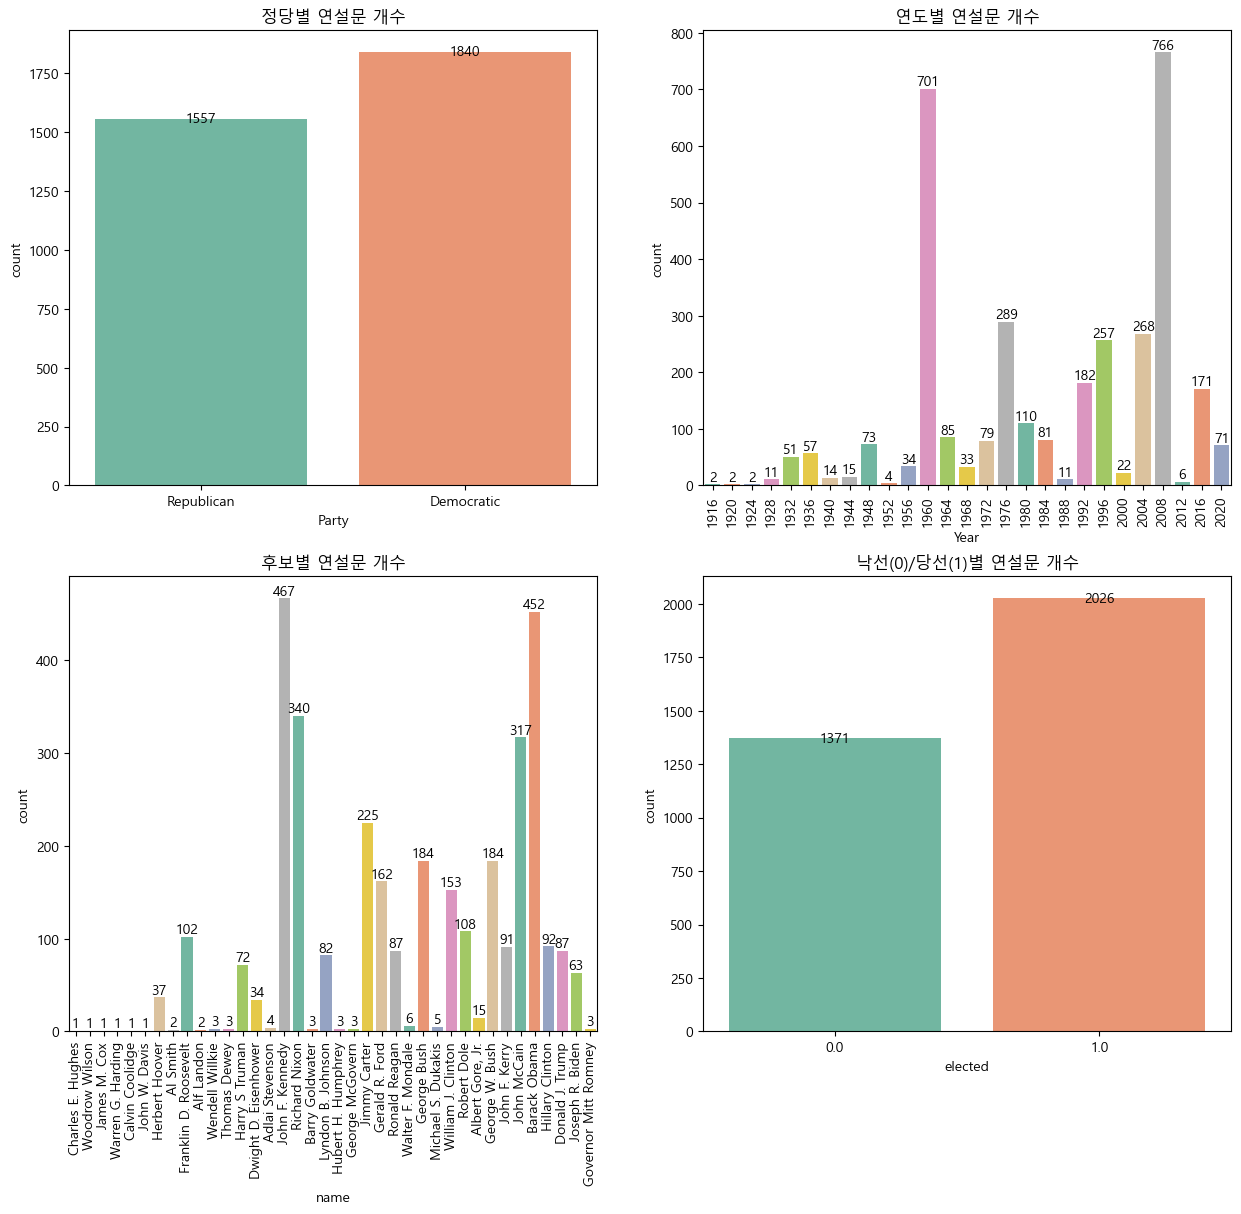

In [231]:
# 문서 개수
fig, axes = plt.subplots(2,2,figsize=(15, 13))
(ax1, ax2, ax3, ax4) = axes.flatten()

# 정당
sns.countplot(x='Party', data=df_anal, palette='Set2', ax=ax1)
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 0),
                textcoords = 'offset points')
ax1.set(title='정당별 연설문 개수')

# 연도
sns.countplot(x='Year', data=df_anal, palette='Set2', ax=ax2)
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
ax2.set(title='연도별 연설문 개수')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

# 후보
sns.countplot(x='name', data=df_anal, palette='Set2', ax=ax3)
for p in ax3.patches:
    ax3.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
ax3.set(title='후보별 연설문 개수')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)

# 당낙선
sns.countplot(x='elected', data=df_anal, palette='Set2', ax=ax4)
for p in ax4.patches:
    ax4.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 0),
                textcoords = 'offset points')
ax4.set(title='낙선(0)/당선(1)별 연설문 개수')

plt.show()

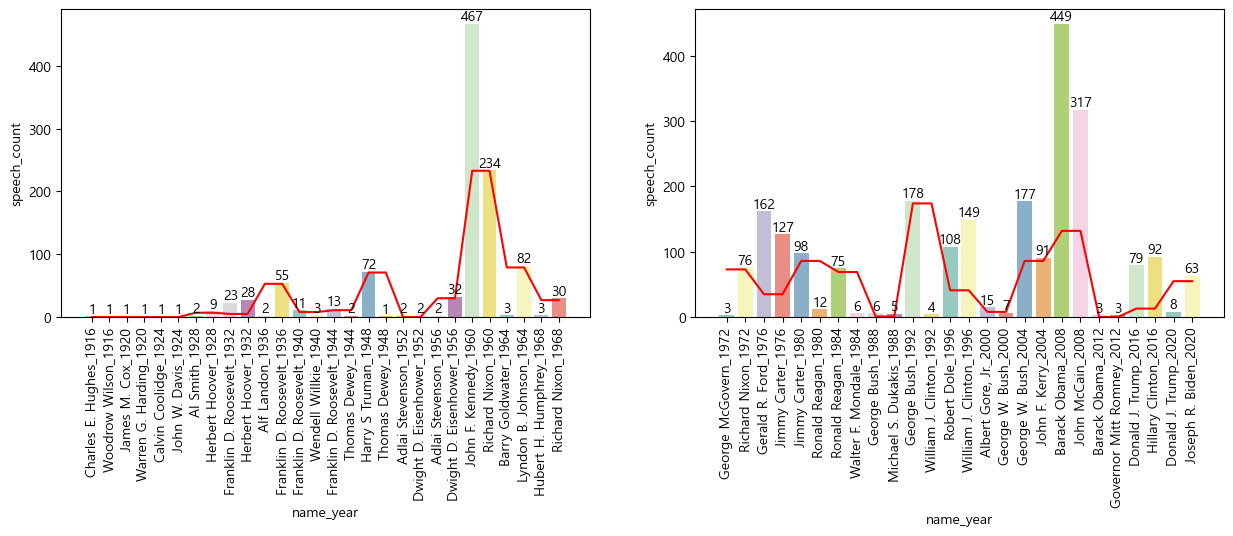

In [232]:
# 해당 연도에 대한 후보자별 문서 개수
fig, axes = plt.subplots(1,2,figsize=(15,4))
(ax1, ax2) = axes.flatten()

sns.barplot(x='name_year', y='speech_count', data=df_cnt[:28], palette='Set3', ax=ax1)
sns.lineplot(x='name_year', y='speech_gap', data=df_cnt[:28], color='red', ax=ax1)
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

sns.barplot(x='name_year', y='speech_count', data=df_cnt[28:], palette='Set3', ax=ax2)
sns.lineplot(x='name_year', y='speech_gap', data=df_cnt[28:], color='red', ax=ax2)
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

plt.show()

In [234]:
df_cnt.sort_values(['speech_gap', 'speech_count'], ascending=False)[:15]

,year,name_year,speech_count,speech_gap
22,1960,John F. Kennedy_1960,467,233
23,1960,Richard Nixon_1960,234,233
38,1992,George Bush_1992,178,174
39,1992,William J. Clinton_1992,4,174
46,2008,Barack Obama_2008,449,132
47,2008,John McCain_2008,317,132
44,2004,George W. Bush_2004,177,86
32,1980,Jimmy Carter_1980,98,86
45,2004,John F. Kerry_2004,91,86
33,1980,Ronald Reagan_1980,12,86


## 2. 분야별 분석

### 1. 분야별 키워드 빈도수 분석

In [60]:
def corpus_freq(field_keyword):
    keyowrd_freq_1 = []
    speech = df_anal['speech_whole']

    for sen in tqdm(speech):
        cnt=0
        for keyword in field_keyword:
            if keyword in sen.lower():
                cnt+=1
        keyowrd_freq_1.append(cnt)
    return keyowrd_freq_1

In [61]:
# 과학관련 키워드 200

sci_keyword = set([
    'atom', 'molecule', 'cell', 'organism', 'tissue', 
    'organ', 'system', 'ecosystem', 'biosphere', 'species', 
    'genome', 'gene', 'chromosome', 'dna', 'rna', 
    'protein', 'enzyme', 'metabolism', 'photosynthesis', 'respiration', 
    'mitosis', 'meiosis', 'evolution', 'mutation', 'adaptation', 
    'natural', 'selection', 'ecology', 'biome', 'habitat', 
    'niche', 'population', 'community', 'biomass', 'trophic', 
    'food', 'chain', 'web', 'energy', 'matter', 
    'quantum', 'particle', 'atom', 'ion', 'electron', 
    'proton', 'neutron', 'photon', 'neutrino', 'boson', 
    'fermion', 'field', 'force', 'gravity', 'magnetism', 
    'electricity', 'magnet', 'current', 'voltage', 'resistance', 
    'circuit', 'capacitance', 'inductance', 'thermodynamics', 'entropy', 
    'enthalpy', 'kinetics', 'catalysis', 'reaction', 'solution', 
    'solvent', 'solute', 'concentration', 'equilibrium', 'pH', 
    'buffer', 'redox', 'oxidation', 'reduction', 'acidity', 
    'alkalinity', 'isotope', 'radioactivity', 'decay', 'half-life', 
    'radiation', 'nuclear', 'fusion', 'fission', 'cellular', 
    'organelle', 'mitochondria', 'chloroplast', 'ribosome', 'endoplasmic', 
    'reticulum', 'golgi', 'lysosome', 'vacuole', 'cytoskeleton', 
    'membrane', 'phospholipid', 'carbohydrate', 'lipid', 'nucleic', 
    'acid', 'amino', 'peptide', 'polypeptide', 'antibody', 
    'antigen', 'hormone', 'neurotransmitter', 'receptor', 'transcription', 
    'translation', 'genotype', 'phenotype', 'inheritance', 'genetics', 
    'biotechnology', 'genetic', 'engineering', 'cloning', 'stem', 
    'cell', 'virology', 'bacteriology', 'mycology', 'parasitology', 
    'immunology', 'pathogen', 'disease', 'epidemic', 'pandemic', 
    'vaccination', 'antibiotic', 'antiviral', 'epigenetics', 'pharmacology', 
    'toxicology', 'physiology', 'anatomy', 'histology', 'embryology', 
    'evolutionary', 'paleontology', 'astronomy', 'cosmology', 'planet', 
    'star', 'galaxy', 'universe', 'nebula', 'black', 
    'hole', 'supernova', 'quasar', 'dark', 'matter', 
    'dark', 'energy', 'redshift', 'blue', 'shift', 
    'parallax', 'light', 'years', 'astronomical', 'unit', 
    'telescopes', 'satellite', 'probe', 'space', 'time', 
    'relativity', 'string', 'theory', 'quantum', 'mechanics', 
    'thermodynamics', 'special', 'general', 'gravitational', 'waves', 
    'entanglement', 'superconductivity', 'nanotechnology', 'molecular', 'biophysics',
    'isomer', 'catalyst', 'reactant', 'product', 'photonics', 
    'spectroscopy', 'chromatography', 'microscopy', 'astronaut', 'hydrolysis', 
    'thermochemistry', 'stoichiometry', 'biochemistry', 'nanoscale', 'electrodynamics', 
    'optics', 'pharmacogenomics', 'seismology', 'geophysics', 'meteorology', 
    'climatology', 'oceanography'
])

sci_keyword = set(sci_keyword)
len(sci_keyword)

205

In [62]:
sci_cnt = corpus_freq(sci_keyword)

100%|██████████| 3397/3397 [00:19<00:00, 170.65it/s]


In [63]:
# 경제 키워드 200개
econ_keyword = set([
    'inflation', 'deflation', 'stagflation', 'recession', 'depression', 
    'gdp', 'cpi', 'ppi', 'unemployment', 'employment', 
    'investment', 'consumption', 'production', 'distribution', 'allocation', 
    'taxation', 'subsidy', 'budget', 'deficit', 'surplus', 
    'tariff', 'quota', 'trade', 'export', 'import', 
    'currency', 'exchange', 'interest', 'savings', 'loan', 
    'mortgage', 'bond', 'stock', 'equity', 'dividend', 
    'capital', 'labor', 'land', 'entrepreneurship', 'market', 
    'competition', 'monopoly', 'oligopoly', 'monopsony', 'oligopsony', 
    'price', 'wage', 'rent', 'profit', 'revenue', 
    'cost', 'expense', 'income', 'earnings', 'wealth', 
    'poverty', 'inequality', 'welfare', 'insurance', 'risk', 
    'return', 'yield', 'valuation', 'appreciation', 'depreciation', 
    'liquidity', 'solvency', 'leverage', 'hedge', 'arbitrage', 
    'speculation', 'investment', 'capitalism', 'socialism', 'communism', 
    'regulation', 'deregulation', 'privatization', 'nationalization', 'globalization', 
    'localization', 'economics', 'microeconomics', 'macroeconomics', 'monetary', 
    'fiscal', 'policy', 'supply', 'demand', 'equilibrium', 
    'elasticity', 'substitute', 'complement', 'inferior', 'normal', 
    'luxury', 'necessity', 'goods', 'services', 'consumer', 
    'producer', 'firms', 'households', 'government', 'foreign', 
    'sector', 'financial', 'institution', 'bank', 'central', 
    'reserve', 'debt', 'credit', 'debit', 'surplus', 
    'deficit', 'tax', 'subsidy', 'grant', 'bailout', 
    'stimulus', 'reform', 'austerity', 'quota', 'sanction', 
    'blockade', 'protectionism', 'liberalization', 'efficiency', 'productivity', 
    'innovation', 'invention', 'technology', 'automation', 'outsourcing', 
    'insourcing', 'offshoring', 'reshoring', 'migration', 'immigration', 
    'emigration', 'demographics', 'population', 'growth', 'development', 
    'sustainability', 'renewable', 'nonrenewable', 'resource', 'scarcity', 
    'abundance', 'choice', 'opportunity', 'cost', 'tradeoff', 
    'specialization', 'division', 'labor', 'economies', 'scale', 
    'diseconomies', 'scope', 'benchmarking', 'forecasting', 'analysis', 
    'model', 'theory', 'hypothesis', 'data', 'statistics', 
    'correlation', 'causation', 'trend', 'cycle', 'boom', 
    'bust', 'bubble', 'crisis', 'recovery', 'expansion', 
    'contraction', 'peak', 'trough', 'plateau', 'stagnation',
    'liability', 'asset', 'collateral', 'deposit', 'withdrawal', 
    'fund', 'portfolio', 'index', 'benchmark', 'option', 
    'derivative', 'futures', 'forward', 'swap', 'tranche', 
    'synergy', 'merger', 'acquisition', 'consolidation', 'divestiture', 
    'liquidation', 'bankruptcy', 'solvent', 'insolvent', 'overdraft', 
    'audit', 'compliance', 'reporting', 'transparency', 'governance'
])
len(econ_keyword)

208

In [64]:
econ_cnt = corpus_freq(econ_keyword)

100%|██████████| 3397/3397 [00:18<00:00, 183.20it/s]


In [3]:
# 환경 키워드 500개

env_keyword = set(
    [
    'ecosystem', 'biodiversity', 'sustainability', 'pollution', 'conservation',
    'habitat', 'climate', 'carbon', 'emissions', 'renewable',
    'nonrenewable', 'deforestation', 'reforestation', 'afforestation', 'desertification',
    'erosion', 'degradation', 'ecology', 'biome', 'wetland',
    'river', 'lake', 'ocean', 'sea', 'forest',
    'grassland', 'desert', 'tundra', 'mountain', 'valley',
    'island', 'shore', 'coast', 'marsh', 'swamp',
    'pollutant', 'waste', 'recycling', 'compost', 'biodegradable',
    'toxins', 'chemical', 'contamination', 'acidification', 'ozone',
    'greenhouse', 'global', 'warming', 'weather', 'temperature',
    'precipitation', 'humidity', 'wind', 'storm', 'hurricane',
    'typhoon', 'tornado', 'drought', 'flood', 'stormwater',
    'runoff', 'sewage', 'sanitation', 'water', 'air',
    'quality', 'smog', 'particulate', 'green', 'energy',
    'solar', 'wind', 'hydro', 'geothermal', 'biomass',
    'fossil', 'fuel', 'coal', 'oil', 'natural',
    'gas', 'nuclear', 'radiation', 'wastewater', 'treatment',
    'sustainable', 'development', 'policy', 'legislation', 'regulation',
    'carbon', 'footprint', 'offset', 'adaptation', 'mitigation',
    'conservation', 'biodiversity', 'restoration', 'ecoservices', 'ecotourism',
    'organic', 'farming', 'pesticide', 'herbicide', 'fertilizer',
    'irrigation', 'hydrology', 'geomorphology', 'soil', 'landscape',
    'geology', 'tectonics', 'volcano', 'earthquake', 'biogeochemical',
    'cycle', 'nitrogen', 'phosphorus', 'carbon', 'water',
    'habitat', 'fragmentation', 'migration', 'species', 'invasive',
    'endangered', 'extinct', 'threatened', 'protected', 'reserve',
    'national', 'park', 'wildlife', 'refuge', 'sanctuary',
    'environmental', 'impact', 'assessment', 'audit', 'monitoring',
    'restoration', 'reclamation', 'preservation', 'safety', 'risk',
    'hazard', 'emergency', 'disaster', 'management', 'response',
    'mitigation', 'adaptation', 'strategies', 'technologies', 'innovations',
    'education', 'awareness', 'advocacy', 'activism', 'lobbying',
    'socioeconomic', 'effects', 'equity', 'justice', 'policy',
    'framework', 'international', 'agreement', 'protocol', 'convention',
    'sustainable', 'development', 'goals', 'population', 'growth',
    'urban', 'sprawl', 'transportation', 'land-use', 'planning',
    'greenhouse', 'gases', 'carbon', 'dioxide', 'methane',
    'nitrous', 'oxide', 'ozone', 'layer', 'depletion',
    'airborne', 'particles', 'emission', 'control', 'legislation',
    'environment', 'ally', 'ecosystem', 'services', 'bioindicator',
    'climate', 'zone', 'geothermal', 'albedo', 'sustainable',
    'landfill', 'overfishing', 'aquifer', 'recycling', 'wilderness',
    'pollinator', 'biotic', 'abiotic', 'dams', 'siltation',
    'habitat', 'corridor', 'greenwashing', 'overconsumption', 'biomagnification',
    'biofuel', 'aquaculture', 'ecotone'
])

len(env_keyword)

200

In [4]:
env_cnt = corpus_freq(env_keyword)

NameError: name 'corpus_freq' is not defined

In [67]:
edu_keyword = set(
    [
    'curriculum', 'pedagogy', 'assessment', 'evaluation', 'learning',
    'teaching', 'instruction', 'school', 'student', 'teacher',
    'classroom', 'syllabus', 'textbook', 'lecture', 'seminar',
    'workshop', 'homework', 'assignment', 'exam', 'quiz',
    'grade', 'feedback', 'accreditation', 'diploma', 'degree',
    'certificate', 'course', 'module', 'program', 'major',
    'minor', 'elective', 'prerequisite', 'graduation', 'enrollment',
    'registration', 'attendance', 'participation', 'dissertation', 'thesis',
    'research', 'methodology', 'hypothesis', 'data', 'analysis',
    'review', 'study', 'project', 'presentation', 'collaboration',
    'discussion', 'debate', 'tutorial', 'mentorship', 'guidance',
    'counseling', 'intervention', 'remediation', 'enrichment', 'extra',
    'curricular', 'extracurricular', 'student', 'center', 'library',
    'resources', 'digital', 'technology', 'e-learning', 'online',
    'platform', 'tool', 'software', 'application', 'network',
    'internet', 'web', 'forum', 'blog', 'podcast',
    'video', 'tutorial', 'webinar', 'courseware', 'module',
    'quiz', 'game', 'simulation', 'interactive', 'activity',
    'participatory', 'engagement', 'self-directed', 'autonomous', 'collaborative',
    'cooperative', 'peer', 'group', 'individual', 'personalized',
    'adaptive', 'differentiated', 'inclusive', 'special', 'needs',
    'gifted', 'talented', 'remedial', 'behavioral', 'support',
    'administration', 'policy', 'regulation', 'governance', 'leadership',
    'management', 'strategic', 'planning', 'budget', 'funding',
    'grant', 'scholarship', 'loan', 'tuition', 'fee',
    'payment', 'financial', 'aid', 'resource', 'allocation',
    'infrastructure', 'facility', 'equipment', 'technology', 'software',
    'hardware', 'resource', 'center', 'lab', 'studio',
    'fieldwork', 'practicum', 'internship', 'placement', 'service',
    'community', 'outreach', 'partnership', 'collaboration', 'network',
    'association', 'society', 'conference', 'symposium', 'forum',
    'workshop', 'seminar', 'training', 'certification', 'continuing',
    'education', 'professional', 'development', 'competency', 'skill',
    'literacy', 'numeracy', 'fluency', 'proficiency', 'aptitude',
    'competence', 'knowledge', 'understanding', 'awareness', 'insight',
    'innovation', 'creativity', 'critical', 'thinking', 'problem-solving',
    'analytical', 'evaluation', 'reflection', 'self-assessment', 'peer-assessment',
    'formative', 'summative', 'norm-referenced', 'criterion-referenced', 'standard',
    'benchmark', 'outcome', 'goal', 'objective', 'target',
    'criteria', 'rubric', 'scale', 'metric', 'indicator',
    'report', 'transcript', 'record', 'portfolio', 'evidence',
    'achievement', 'progress', 'performance', 'development', 'growth',
    'expansion', 'advancement', 'success', 'failure', 'challenge',
    'barrier', 'obstacle', 'enabler', 'motivator', 'incentive',
    'reward', 'recognition', 'celebration', 'graduation', 'commencement'
])
len(edu_keyword)

209

In [68]:
edu_cnt = corpus_freq(edu_keyword)

  0%|          | 0/3397 [00:00<?, ?it/s]

100%|██████████| 3397/3397 [00:18<00:00, 183.23it/s]


In [69]:
sec_keyword = set(
    [
    'intelligence', 'surveillance', 'counterterrorism', 'cybersecurity', 'espionage',
    'security', 'defense', 'military', 'conflict', 'terrorism',
    'threat', 'risk', 'border', 'patrol', 'inspection',
    'detection', 'prevention', 'response', 'crisis', 'management',
    'emergency', 'protocol', 'alert', 'warning', 'defense',
    'strategy', 'policy', 'operation', 'taskforce', 'agency',
    'intelligence', 'agency', 'counterintelligence', 'decryption', 'encryption',
    'classified', 'information', 'leak', 'secret', 'confidential',
    'authorization', 'clearance', 'safeguard', 'mitigation', 'protection',
    'vulnerability', 'exposure', 'security', 'audit', 'assessment',
    'incident', 'investigation', 'reconnaissance', 'surveillance', 'monitoring',
    'intervention', 'control', 'engagement', 'sanction', 'embargo',
    'diplomacy', 'negotiation', 'treaty', 'agreement', 'alliance',
    'coalition', 'force', 'unit', 'deployment', 'strategy',
    'militant', 'guerrilla', 'insurgent', 'rebel', 'military',
    'hardware', 'software', 'network', 'infrastructure', 'cyber',
    'security', 'penetration', 'attack', 'malware', 'virus',
    'trojan', 'worm', 'phishing', 'ransomware', 'firewall',
    'vulnerability', 'exploit', 'breach', 'intrusion', 'security',
    'protocol', 'authentication', 'authorization', 'identity', 'credential',
    'access', 'control', 'data', 'privacy', 'safeguard',
    'espionage', 'agent', 'spy', 'surveillance', 'intercept',
    'transmission', 'communications', 'monitor', 'detect', 'track',
    'neutralize', 'countermeasure', 'debrief', 'training', 'drill',
    'exercise', 'readiness', 'alert', 'response', 'action',
    'operation', 'plan', 'contingency', 'recovery', 'reinforcement',
    'deployment', 'strategy', 'tactic', 'engagement', 'collaboration',
    'interagency', 'coordination', 'situation', 'intelligence', 'analysis',
    'briefing', 'report', 'memo', 'directive', 'protocol',
    'order', 'command', 'command', 'control', 'communications',
    'surveillance', 'patrol', 'border', 'check', 'screen',
    'detain', 'arrest', 'detention', 'interrogation', 'custody',
    'prosecution', 'defense', 'judicial', 'legal', 'case',
    'crime', 'criminal', 'offense', 'violation', 'transgression',
    'regulation', 'law', 'legislation', 'statute', 'ordinance',
    'directive', 'mandate', 'enforcement', 'compliance', 'monitoring',
    'audit', 'investigation', 'assessment', 'evaluation', 'review',
    'audit', 'inspection', 'assessment', 'evaluation', 'review',
    'countermeasure', 'deterrent', 'mitigation', 'resilience', 'adaptation',
    'recovery', 'response', 'readiness', 'training', 'preparedness',
    'operational', 'security', 'policy', 'strategy', 'plan',
    'control', 'command', 'strategy', 'policy', 'regulation',
    'procedure', 'guideline', 'protocol', 'framework', 'system',
    'network', 'infrastructure', 'support', 'protection', 'response',
    'incident', 'event', 'situation', 'condition', 'status',
    'operational', 'effectiveness', 'efficiency', 'capability', 'resource',
    'intervention', 'forensics', 'countermeasures', 'disaster', 'recovery',
    'scenario', 'brief', 'tactical', 'strategic', 'counter',
    'intelligence', 'threats', 'vigilance', 'operations', 'surveillance',
    'asset', 'security', 'protection', 'conflict', 'crisis',
    'response', 'preparation', 'mobilization', 'contingency', 'risk',
    'threatening', 'risk', 'hazard', 'situation', 'incident',
    'intercept', 'coordination', 'support', 'asset', 'logistics',
    'safety', 'precaution', 'security', 'compromise', 'protocol',
    'radicalization', 'extremism', 'jihad', 'militant', 'insurgent',
    'terrorist', 'bombing', 'attack', 'hostage', 'extortion',
    'fundamentalism', 'guerrilla', 'clandestine', 'cell', 'network',
    'propaganda', 'recruitment', 'violence', 'sabotage', 'crisis',
    'security', 'threat'
])
len(sec_keyword)

200

In [70]:
sec_cnt = corpus_freq(sec_keyword)

100%|██████████| 3397/3397 [00:18<00:00, 184.42it/s]


In [ ]:
# 특정 연도에 출마한 후보당 키워드 출현 횟수 데이터
# 코드 다 짰는데 파일이 날아가고.. 천만다행으로 데이터만 남음

# df_anal_2.to_csv(r"E:\est\kdt\project\president_prediction\data\df_anal_2.csv")
df_anal_2 = pd.read_csv(r"E:\est\kdt\project\president_prediction\data\df_anal_2.csv", index_col=0)
df_anal_2.tail(2)

,Year,name_year,sci_cnt,econ_cnt,env_cnt,edu_cnt,sec_cnt,elected,Party,Elections_Won
52,2020,2020_Donald J. Trump,28.0,26.0,30.0,39.0,40.0,0.0,Republican,0.0
53,2020,2020_Joseph R. Biden,22.0,24.0,25.0,33.0,33.0,1.0,Democratic,1.0


In [141]:
df_word = df_anal[['name', 'elected', 'Year', 'Party']].copy()
df_word['sci_cnt'] = sci_cnt
df_word['econ_cnt'] = econ_cnt
df_word['env_cnt'] = env_cnt
df_word['edu_cnt'] = edu_cnt
df_word['sec_cnt'] = sec_cnt
df_word['Party'] = df_word['Party'].replace({'Republican': 0, 'Democratic': 1})

df_anal_3 = df_word.pivot_table(index=['Year','name'], 
                                aggfunc=np.mean
                                ).reindex(columns=['elected', 'Party', 'sci_cnt', 'econ_cnt', 'env_cnt', 'edu_cnt', 'sec_cnt']).sort_values('Year').round().reset_index()

df_anal_3['Party'] = df_anal_3['Party'].replace({0: 'Republican', 1: 'Democratic'})
df_anal_3['elected'] = df_anal_3['elected'].replace({0.0 : 'loss', 1.0 : 'win'})
df_anal_3.to_csv(r"E:\est\kdt\project\president_prediction\data\df_anal_3.csv")

In [7]:
df_anal_3 = pd.read_csv(r"E:\est\kdt\project\president_prediction\data\df_anal_3.csv", index_col=0)
df_anal_3.tail()

,Year,name,elected,Party,sci_cnt,econ_cnt,env_cnt,edu_cnt,sec_cnt
49,2012,Governor Mitt Romney,loss,Republican,23.0,52.0,28.0,48.0,35.0
50,2016,Donald J. Trump,win,Republican,18.0,30.0,19.0,25.0,31.0
51,2016,Hillary Clinton,loss,Democratic,17.0,24.0,15.0,29.0,25.0
52,2020,Donald J. Trump,loss,Republican,19.0,26.0,18.0,23.0,29.0
53,2020,Joseph R. Biden,win,Democratic,15.0,22.0,15.0,21.0,21.0


In [10]:
# 연도별 키워드 추세를 알기 위해서 피봇테이블 변환

df_anal_2_year = df_anal_2.pivot_table(index='Year', 
                                       aggfunc=np.sum, 
                                       values=['sci_cnt', 'econ_cnt', 'env_cnt', 'edu_cnt', 'sec_cnt']
                                      )
df_anal_2_year.head(2)

,econ_cnt,edu_cnt,env_cnt,sci_cnt,sec_cnt
Year,,,,,
1916,79.0,92.0,68.0,44.0,98.0
1920,150.0,179.0,115.0,83.0,173.0


In [6]:
def field_count(df, field_cnt, field_name):
    yes_data = df[df['elected'] == 'win']
    no_data = df[df['elected'] == 'loss']
    do_data = df[df['Party'] == 'Democratic']
    re_data = df[df['Party'] == 'Republican']
    palette = sns.color_palette('Set2')
    yes_color = palette[0]
    no_color = palette[1]
    skyblue = '#4c72b0'
    coralred = '#c44e52'
    years = sorted(df['Year'].unique())

    # fig, ax = plt.subplots(3, 1, figsize=(12, 18))
    # (ax1, ax2, ax3) = ax.flatten()

    fig, ax = plt.subplots(2, 1, figsize=(12, 12))
    (ax1, ax2) = ax.flatten()

    # 당락으로 구분
    ax1.bar(yes_data['Year'], yes_data[field_cnt], label='당선', color=yes_color, width=3)
    ax1.bar(no_data['Year'], no_data[field_cnt], label='낙선', color=no_color, width=1.5)
    ax1.set_title(f'연도별 {field_name} 키워드 등장 횟수(대선 당락)', fontsize=16)
    ax1.set_xlabel('4년 단위 연도')
    ax1.set_ylabel(f'{field_name} 키워드 등장 횟수')
    ax1.legend(title='대선 당락여부')
    ax1.set_xticks(years[::2]) # x 축 레이블을 2개당 하나씩 표시

    # 정당으로 구분
    ax2.bar(do_data['Year'], do_data[field_cnt], label='민주당', color=skyblue, width=3)
    ax2.bar(re_data['Year'], re_data[field_cnt], label='공화당', color=coralred, width=1.5)
    ax2.set_title(f'연도별 {field_name} 키워드 등장 횟수(정당)', fontsize=16)
    ax2.set_xlabel('4년 단위 연도')
    ax2.set_ylabel(f'{field_name} 키워드 등장 횟수')
    ax2.legend(title='정당')
    ax2.set_xticks(years[::2]) # x 축 레이블을 2개당 하나씩 표시

    # # 연도별 키워드 등장 총 횟수
    # sns.lineplot(x='Year', y=field_cnt, data=df_anal_2_year, ax=ax3, label=f'{field_name} 키워드 등장 횟수')
    # ax3.set_title(f'연도별 {field_name} 키워드 총 등장 횟수', fontsize=16)
    # ax3.set_xlabel('4년 단위 연도')
    # ax3.set_ylabel(f'{field_name} 키워드 총 등장 횟수')
    

    plt.show()

In [128]:
# 씨본은 겹쳐서 그릴 수가 없는듯?

# fig, ax = plt.subplots(figsize=(12, 4))

# sns.barplot(x='Year', y='sci_cnt', data=df_anal_2, hue='elected', palette='Set2', ax=ax)

# ax.set_title('연도별 과학 키워드 등장 횟수')
# ax.set_xlabel('연도')
# ax.set_ylabel('Science Count')

# ax.legend(title='대선 당락 여부')
# plt.show()

#### 1) 과학 키워드로 빈도수 분석

In [10]:
# 각 분야별 상위 몇위까지 볼것인지 선택
rank = 14

In [143]:
# df_science = df_anal_2[['Year','name_year', 'elected', 'Party', 'sci_cnt']].sort_values('sci_cnt', ascending=False).reset_index(drop=True)[:rank]
df_science = df_anal_3[['Year','name', 'elected', 'Party', 'sci_cnt']].sort_values('sci_cnt', ascending=False).reset_index(drop=True)[:rank]
df_science

,Year,name,elected,Party,sci_cnt
0,1920,James M. Cox,loss,Democratic,36.0
1,1924,Calvin Coolidge,win,Republican,29.0
2,1916,Woodrow Wilson,win,Democratic,28.0
3,2012,Barack Obama,win,Democratic,25.0
4,1924,John W. Davis,loss,Democratic,25.0
5,1928,Herbert Hoover,win,Republican,23.0
6,2012,Governor Mitt Romney,loss,Republican,23.0
7,1920,Warren G. Harding,win,Republican,23.0
8,1928,Al Smith,loss,Democratic,22.0
9,1932,Franklin D. Roosevelt,win,Democratic,20.0


In [145]:
# 상위 14위에서 비율

print(df_science['elected'].value_counts())
print()
print(df_science['Party'].value_counts())

elected
win     9
loss    5
Name: count, dtype: int64

Party
Democratic    7
Republican    7
Name: count, dtype: int64


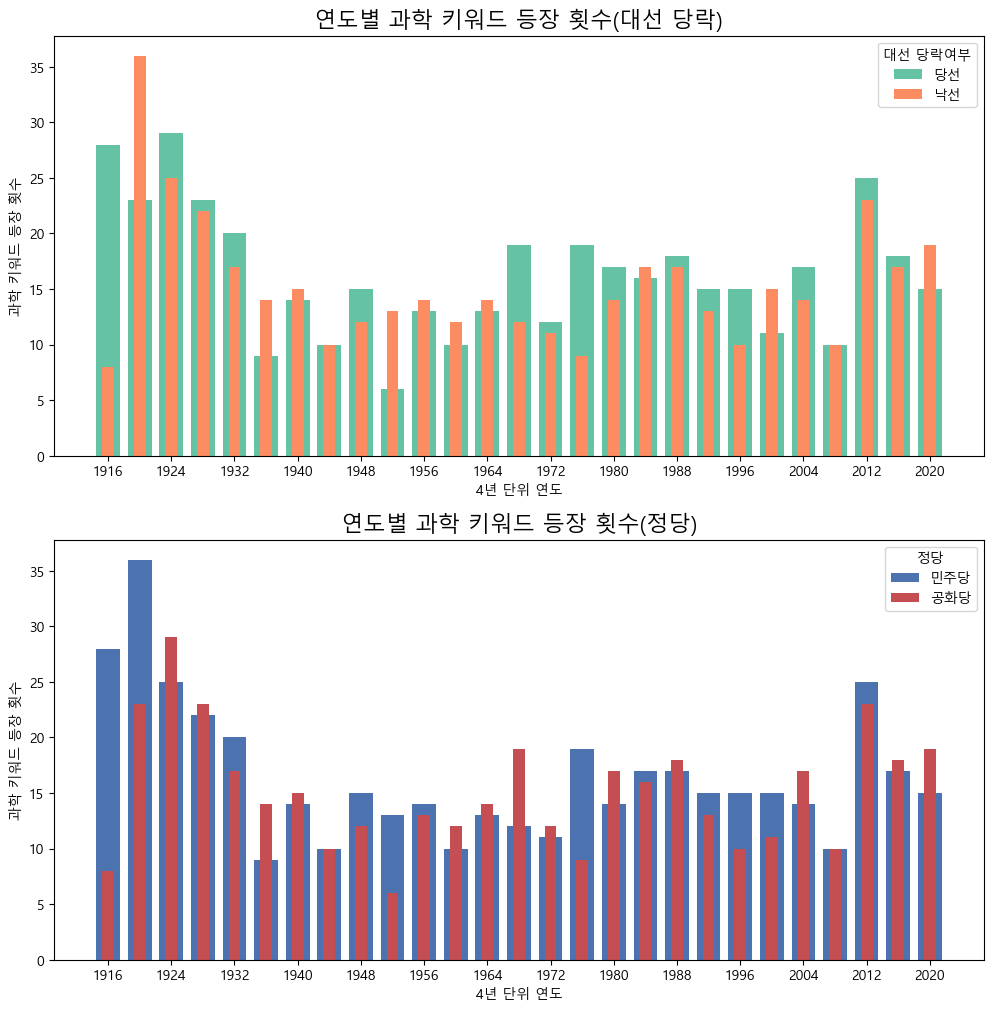

In [147]:
field_count(df_anal_3, 'sci_cnt', '과학')

#### 2) 경제 키워드로 빈도수 분석

In [152]:
# df_economy = df_anal_2[['Year','name_year', 'elected', 'Party', 'econ_cnt']].sort_values('econ_cnt', ascending=False).reset_index(drop=True)[:rank]
df_economy = df_anal_3[['Year','name', 'elected', 'Party', 'econ_cnt']].sort_values('econ_cnt', ascending=False).reset_index(drop=True)[:rank]
df_economy

,Year,name,elected,Party,econ_cnt
0,1920,James M. Cox,loss,Democratic,78.0
1,1924,John W. Davis,loss,Democratic,70.0
2,1924,Calvin Coolidge,win,Republican,64.0
3,1920,Warren G. Harding,win,Republican,63.0
4,1916,Woodrow Wilson,win,Democratic,54.0
5,1928,Herbert Hoover,win,Republican,54.0
6,2012,Barack Obama,win,Democratic,53.0
7,2012,Governor Mitt Romney,loss,Republican,52.0
8,1928,Al Smith,loss,Democratic,45.0
9,1932,Franklin D. Roosevelt,win,Democratic,44.0


In [153]:
# 상위 14위에서 비율

print(df_economy['elected'].value_counts())
print()
print(df_economy['Party'].value_counts())

elected
win     9
loss    5
Name: count, dtype: int64

Party
Republican    8
Democratic    6
Name: count, dtype: int64


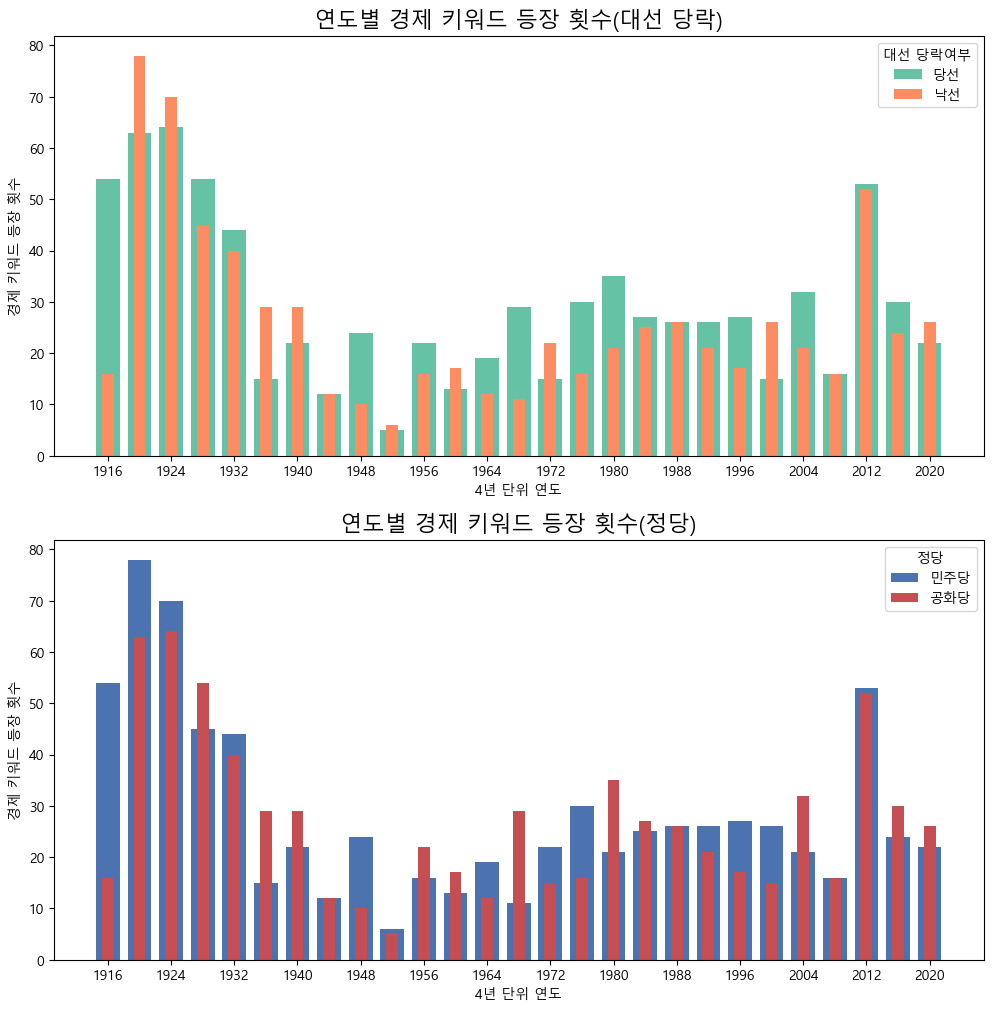

In [148]:
field_count(df_anal_3, 'econ_cnt', '경제')

#### 3) 환경 키워드로 빈도수 분석

In [11]:
# df_environment = df_anal_2[['Year','name_year', 'elected', 'Party', 'econ_cnt']].sort_values('econ_cnt', ascending=False).reset_index(drop=True)[:rank]
df_environment = df_anal_3[['Year','name', 'elected', 'Party', 'env_cnt']].sort_values('env_cnt', ascending=False).reset_index(drop=True)[:rank]
df_environment

,Year,name,elected,Party,env_cnt
0,1920,James M. Cox,loss,Democratic,45.0
1,1920,Warren G. Harding,win,Republican,40.0
2,1924,Calvin Coolidge,win,Republican,32.0
3,1924,John W. Davis,loss,Democratic,30.0
4,2012,Barack Obama,win,Democratic,28.0
5,2012,Governor Mitt Romney,loss,Republican,28.0
6,1916,Woodrow Wilson,win,Democratic,28.0
7,1928,Herbert Hoover,win,Republican,26.0
8,1928,Al Smith,loss,Democratic,23.0
9,1980,Ronald Reagan,win,Republican,23.0


In [12]:
# 상위 14위에서 비율

print(df_environment['elected'].value_counts())
print()
print(df_environment['Party'].value_counts())

elected
win     10
loss     4
Name: count, dtype: int64

Party
Democratic    7
Republican    7
Name: count, dtype: int64


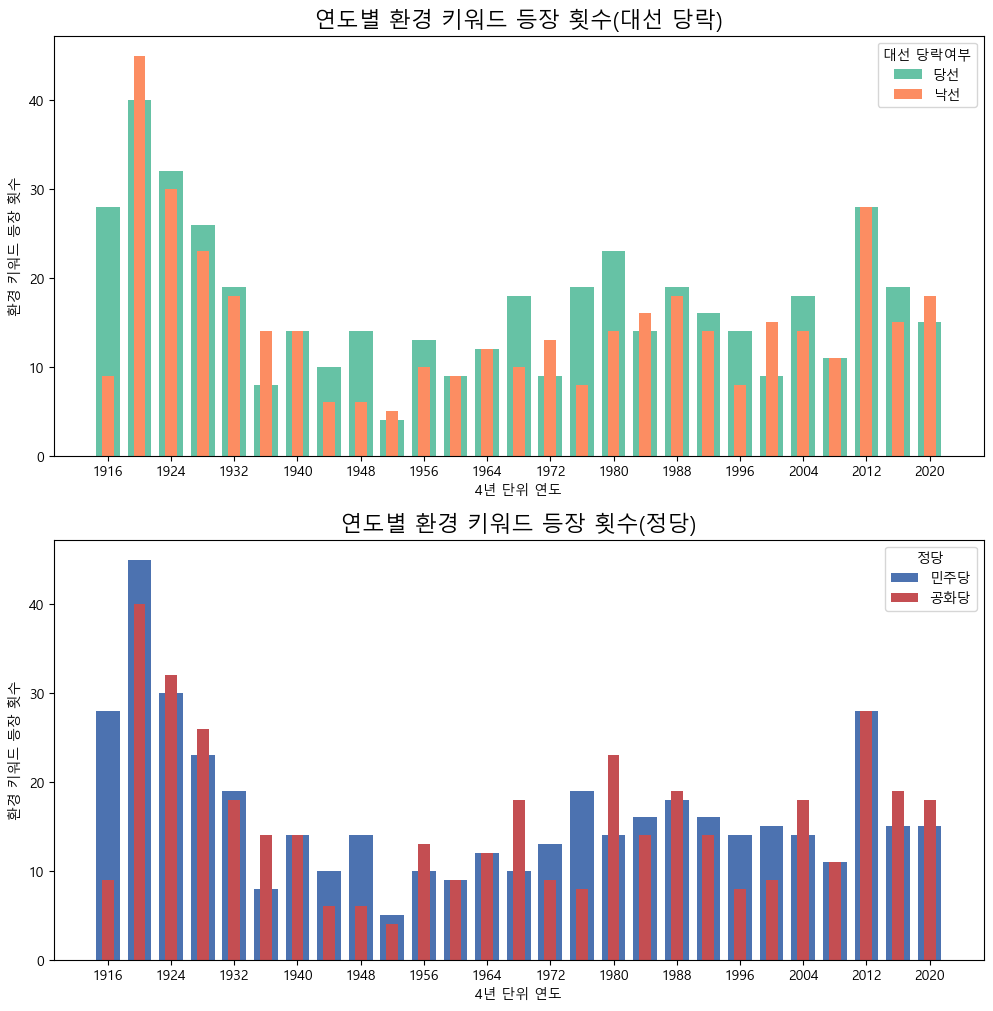

In [13]:
field_count(df_anal_3, 'env_cnt', '환경')

#### 4) 교육 키워드로 빈도수 분석

In [156]:
# 상위 14위에서 비율

# df_education = df_anal_2[['Year','name_year', 'elected', 'Party', 'edu_cnt']].sort_values('edu_cnt', ascending=False).reset_index(drop=True)[:rank]
df_education = df_anal_3[['Year','name', 'elected', 'Party', 'edu_cnt']].sort_values('edu_cnt', ascending=False).reset_index(drop=True)[:rank]
df_education

,Year,name,elected,Party,edu_cnt
0,1920,James M. Cox,loss,Democratic,65.0
1,1924,Calvin Coolidge,win,Republican,57.0
2,1924,John W. Davis,loss,Democratic,53.0
3,1920,Warren G. Harding,win,Republican,49.0
4,2012,Governor Mitt Romney,loss,Republican,48.0
5,2012,Barack Obama,win,Democratic,47.0
6,1916,Woodrow Wilson,win,Democratic,44.0
7,1928,Al Smith,loss,Democratic,39.0
8,1928,Herbert Hoover,win,Republican,39.0
9,1968,Richard Nixon,win,Republican,35.0


In [157]:
# 상위 14위에서 비율

print(df_education['elected'].value_counts())
print()
print(df_education['Party'].value_counts())

elected
win     10
loss     4
Name: count, dtype: int64

Party
Democratic    7
Republican    7
Name: count, dtype: int64


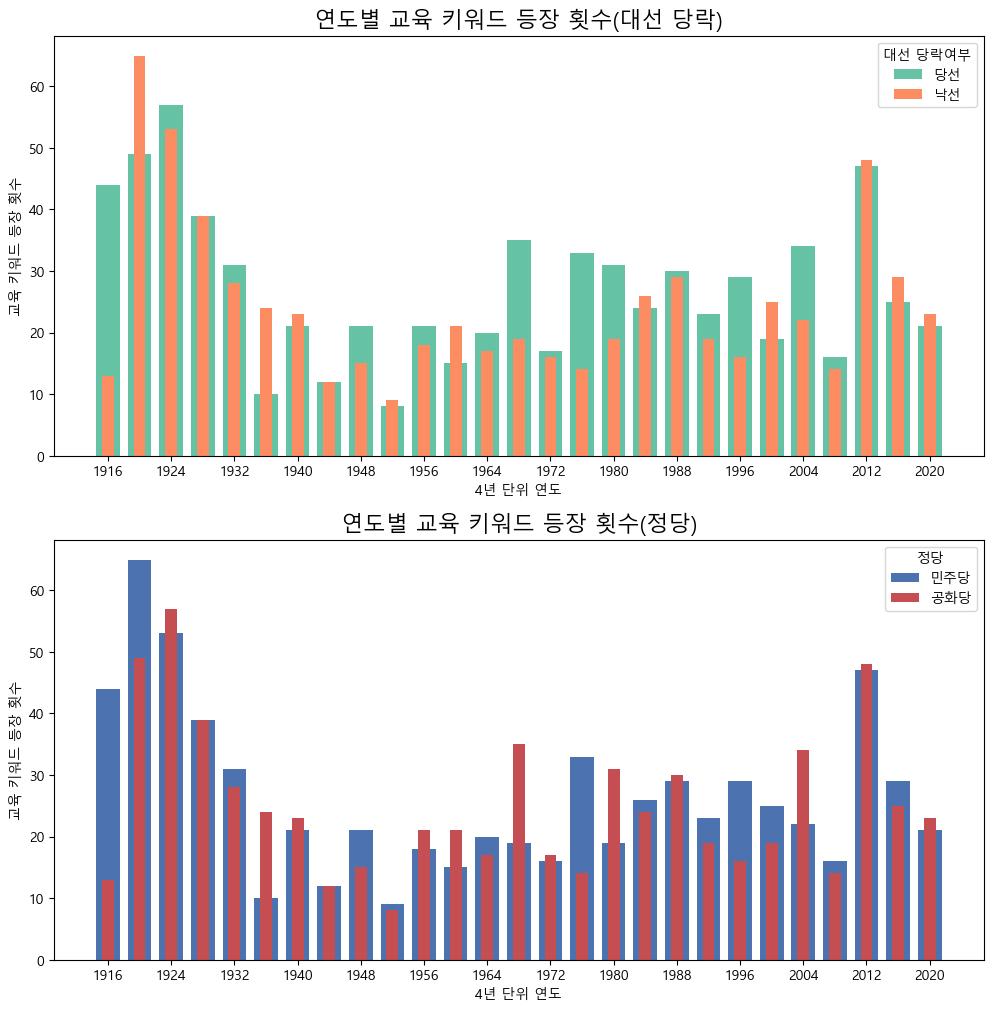

In [150]:
field_count(df_anal_3, 'edu_cnt', '교육')

#### 5) 안보 키워드로 빈도수 분석

In [158]:
# 상위 14위에서 비율

# df_security = df_anal_2[['Year','name_year', 'elected', 'Party', 'sec_cnt']].sort_values('sec_cnt', ascending=False).reset_index(drop=True)[:rank]
df_security = df_anal_3[['Year','name', 'elected', 'Party', 'sec_cnt']].sort_values('sec_cnt', ascending=False).reset_index(drop=True)[:rank]
df_security

,Year,name,elected,Party,sec_cnt
0,1920,James M. Cox,loss,Democratic,64.0
1,1920,Warren G. Harding,win,Republican,52.0
2,1924,John W. Davis,loss,Democratic,47.0
3,1916,Woodrow Wilson,win,Democratic,45.0
4,1924,Calvin Coolidge,win,Republican,44.0
5,2012,Barack Obama,win,Democratic,42.0
6,2012,Governor Mitt Romney,loss,Republican,35.0
7,1928,Al Smith,loss,Democratic,33.0
8,2016,Donald J. Trump,win,Republican,31.0
9,2004,George W. Bush,win,Republican,31.0


In [159]:
# 상위 14위에서 비율

print(df_security['elected'].value_counts())
print()
print(df_security['Party'].value_counts())

elected
win     8
loss    6
Name: count, dtype: int64

Party
Democratic    7
Republican    7
Name: count, dtype: int64


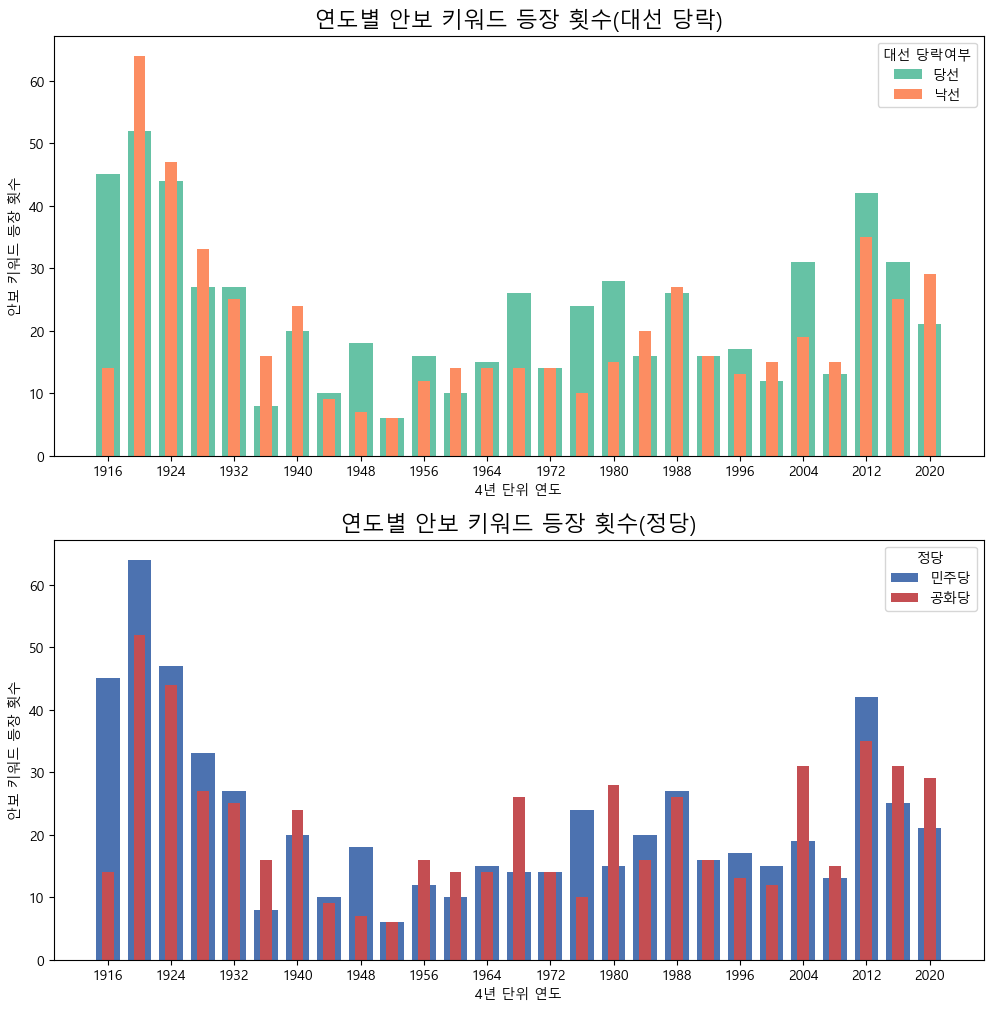

In [151]:
field_count(df_anal_3, 'sec_cnt', '안보')

### 2. KeyBERT
 - 연도별 / 인물별 중요 키워드 분석

```
1916 - World War I
1920 - Women's Suffrage
1924 - Immigration Act
1928 - Economic Prosperity
1932 - Great Depression
1936 - New Deal
1940 - World War II
1944 - World War II
1948 - Cold War
1952 - Korean War
1956 - Civil Rights Movement
1960 - Kennedy Elected
1964 - Civil Rights Act
1968 - Civil Rights and Protests
1972 - Watergate
1976 - Bicentennial
1980 - Reagan Elected
1984 - Reagan Re-elected
1988 - Bush Elected
1992 - Clinton Elected
1996 - Clinton Re-elected
2000 - Election Dispute
2004 - Iraq War
2008 - Financial Crisis and Obama Elected
2012 - Obama Re-elected
2016 - Trump Elected
2020 - COVID-19 and Biden Elected
```

````
1916년: 제1차 세계대전                  미국은 중립을 유지하고 있었지만, 유럽에서 전쟁이 격렬하게 진행 중이었습니다. 또한, 우드로 윌슨 대통령이 재선되었습니다.
1920년: 여성 참정권                     미국 헌법 제19차 수정안이 비준되면서 여성 참정권이 보장되었습니다.
1924년: 이민 제한법                     1924년 이민법(Johnson-Reed Act)이 통과되어 이민자 수를 제한하고 특정 국가 출신의 이민을 억제했습니다.
1928년: 경제 번영기                     1920년대 후반은 경제적으로 번영했던 시기로, 대규모 소비와 산업의 발전이 이루어졌습니다.
1932년: 대공황                          대공황이 절정에 달해 대량 실업과 경제적 어려움이 이어졌습니다. 프랭클린 D. 루즈벨트가 대통령에 당선되었습니다.
1936년: 대공황                          뉴딜 정책이 계속되면서 경제 회복을 위한 다양한 프로그램이 시행되었습니다. 루즈벨트 대통령이 재선되었습니다.
1940년: 제2차 세계대전                  유럽과 아시아에서 전쟁이 확산되고 있었고, 미국은 아직 전쟁에 참전하지 않았지만 준비를 시작했습니다.
1944년: 제2차 세계대전                  미국은 연합군의 일원으로 전쟁에 적극적으로 참여하고 있었습니다. 노르망디 상륙 작전이 이뤄졌고, 루즈벨트 대통령이 네 번째 임기에 당선되었습니다.
1948년: 냉전의 시작                     소련과의 긴장이 높아지면서 냉전이 본격화되었습니다. 해리 S. 트루먼 대통령이 재선되었습니다.
1952년: 한국 전쟁                       한국 전쟁이 진행 중이었으며, 드와이트 D. 아이젠하워가 대통령에 당선되었습니다.
1956년: 남부의 민권 운동                마틴 루터 킹 주니어의 지도하에 몽고메리 버스 보이콧이 성공하면서 민권 운동이 활발해졌습니다. 아이젠하워 대통령이 재선되었습니다.
1960년: 존 F. 케네디의 당선             존 F. 케네디가 대통령에 당선되었고, 텔레비전 토론이 선거에서 중요한 역할을 했습니다.
1964년: 민권법                          린든 B. 존슨 대통령이 민권법(Civil Rights Act)을 서명하여 인종 차별을 금지했습니다.
1968년: 민권 운동과 반전 운동           마틴 루터 킹 주니어와 로버트 F. 케네디의 암살 사건이 발생했습니다. 베트남 전쟁 반대 시위가 격렬해졌습니다.
1972년: 워터게이트 사건                 리처드 닉슨 대통령의 재선과 함께 워터게이트 사건이 발생하여 큰 정치적 스캔들이 되었습니다.
1976년: 미국 건국 200주년               미국 건국 200주년을 기념하는 행사가 열렸고, 지미 카터가 대통령에 당선되었습니다.
1980년: 로널드 레이건의 당선            로널드 레이건이 대통령에 당선되었고, 보수주의 정책이 강화되었습니다.
1984년: 레이건의 재선                   레이건 대통령이 재선에 성공하였고, 경제 회복과 군비 확장 정책이 계속되었습니다.
1988년: 조지 H. W. 부시의 당선          조지 H. W. 부시가 대통령에 당선되었고, 냉전 종식의 기운이 감돌았습니다.
1992년: 빌 클린턴의 당선                빌 클린턴이 대통령에 당선되었고, 경제 회복과 중산층 중심의 정책이 주목받았습니다.
1996년: 클린턴의 재선                   빌 클린턴 대통령이 재선에 성공하였고, 정보화 시대와 글로벌화가 본격화되었습니다.
2000년: 대선 논란                       조지 W. 부시와 앨 고어 간의 대선 결과가 플로리다 재검표 논란으로 이어졌고, 결국 부시가 대통령이 되었습니다.
2004년: 이라크 전쟁                     이라크 전쟁이 지속되는 가운데, 조지 W. 부시 대통령이 재선되었습니다.
2008년: 금융 위기와 오바마의 당선       글로벌 금융 위기가 발생하였고, 버락 오바마가 미국 최초의 아프리카계 미국인 대통령으로 당선되었습니다.
2012년: 오바마의 재선                   버락 오바마 대통령이 재선에 성공하였고, 오바마케어와 같은 정책들이 주목받았습니다.
2016년: 트럼프의 당선                   도널드 트럼프가 대통령에 당선되었고, 미국 정치와 사회에 큰 변화를 불러일으켰습니다.
2020년: 코로나19 팬데믹과 바이든의 당선 코로나19 팬데믹이 전 세계를 강타하였고, 조 바이든이 대통령에 당선되었습니다.
````

#### 1)연도별 연설문 병합

In [29]:
type(df_anal['speech_whole'][0])

str

In [91]:
# 연도별로 문장을 모을 딕셔너리 생성
year_speech = defaultdict(str)

# 데이터프레임 순회하면서 연도별로 문장을 합치기
for idx, row in df_anal.iterrows():
    year = row['Year']
    speech = row['speech_whole']
    year_speech[year] += speech

df_year_speech_1 = pd.DataFrame(list(year_speech.items()), columns=['Year', 'Speech'])
df_year_speech_1.sort_values('Year', inplace=True)

In [92]:
df_year_speech_1.head()

,Year,Speech
0,1916,Mr. Chairman and Delegates: I have not desired...
1,1920,"Chairman Robinson, and members of the Notifica..."
2,1924,"Mr. Chairman, Members of the Committee, Ladies..."
3,1928,"You bring, Mr. Chairman, formal notice of my n..."
4,1932,Mr. Chairman and my fellow citizens: In accept...


In [93]:
### 연도별 keybert 분석

kw_model = KeyBERT()
keybert_year_speech_1 = kw_model.extract_keywords(df_year_speech_1['Speech'], keyphrase_ngram_range=(1, 2), stop_words='english', top_n=30)
df_year_speech_1['keybert_year'] = keybert_year_speech_1
df_year_speech_1.to_csv(r'E:\est\kdt\project\president_prediction\data\year_speech.csv')

In [ ]:
df_year_speech_1 = pd.read_csv(r'E:\est\kdt\project\president_prediction\data\year_speech.csv', index_col=0)

In [74]:
i = 0

df_year_speech_1.loc[i,'Year'], df_year_speech_1.loc[i,'keybert_year']

(1916,
 [('chairman delegates', 0.5029),
  ('desired nomination', 0.4455),
  ('power mexico', 0.439),
  ('mexico powerless', 0.4382),
  ('mexico relations', 0.4367),
  ('congress american', 0.4313),
  ('delegates desired', 0.4288),
  ('accept nomination', 0.4271),
  ('nomination', 0.4201),
  ('delegates', 0.4198),
  ('mexico position', 0.417),
  ('regard mexico', 0.4162),
  ('forces mexico', 0.4155),
  ('nomination wished', 0.413),
  ('nomination stand', 0.4082),
  ('congress adequately', 0.4068),
  ('territory mexico', 0.3949),
  ('affairs mexico', 0.3941),
  ('denying mexicans', 0.3927),
  ('mexico protect', 0.3846),
  ('violation sovereignty', 0.3804),
  ('maintain american', 0.3786),
  ('candidates dictate', 0.3781),
  ('mexican territory', 0.3774),
  ('powers congress', 0.3767),
  ('national sovereignty', 0.3722),
  ('chairman', 0.3687),
  ('authorities mexico', 0.3683),
  ('partisan consideration', 0.3673),
  ('definite pledge', 0.3632)])

- 연도별로 문장(idf제거)

In [160]:
# 연도별로 문장(idf제거)을 모을 딕셔너리 생성
year_speech_2 = defaultdict(str)

# 데이터프레임 순회하면서 연도별로 문장을 합치기
for idx, row in df_anal.iterrows():
    year = row['Year']
    speech = row['whole_remove_idf']
    year_speech_2[year] += speech

df_year_speech_2 = pd.DataFrame(list(year_speech_2.items()), columns=['Year', 'Speech'])
df_year_speech_2.sort_values('Year', inplace=True)

In [161]:
# ## 연도별 keybert(idf제거) 분석

# kw_model = KeyBERT()
# keybert_year_speech_2 = kw_model.extract_keywords(df_year_speech_2['Speech'], keyphrase_ngram_range=(1, 2), stop_words='english', top_n=30)
# df_year_speech_2['keybert_year'] = keybert_year_speech_2
# df_year_speech_2.to_csv(r'E:\est\kdt\project\president_prediction\data\year_speech_remove_idf.csv')

In [1]:
df_year_speech_2 = pd.read_csv(r'E:\est\kdt\project\president_prediction\data\year_speech_remove_idf.csv', index_col=0)

NameError: name 'pd' is not defined

1944 
 [('pledges men', 0.4435), ('man pledges', 0.4413), ('pledge dedicated', 0.4306), ('shall pledges', 0.4302), ('pledges promises', 0.4219), ('pledge utmost', 0.4209), ('pledged lives', 0.3905), ('pledges', 0.3857), ('attached pledge', 0.3835), ('promise elected', 0.3803), ('pledged pledged', 0.3795), ('party pledge', 0.379), ('mobilized shall', 0.3732), ('pledges mouthings', 0.3663), ('pledged', 0.3661), ('pledge', 0.3654), ('request governorship', 0.3636), ('honor presidency', 0.3631), ('principles leader', 0.3625), ('representatives task', 0.3596), ('leadership sought', 0.3595), ('progressive leadership', 0.3591), ('comrades pressing', 0.3569), ('freedom comrades', 0.3555), ('men representatives', 0.3524), ('comradeship spirit', 0.3513), ('gave mandate', 0.3464), ('word behalf', 0.3463), ('governor cooperating', 0.3451), ('leader', 0.3438)]


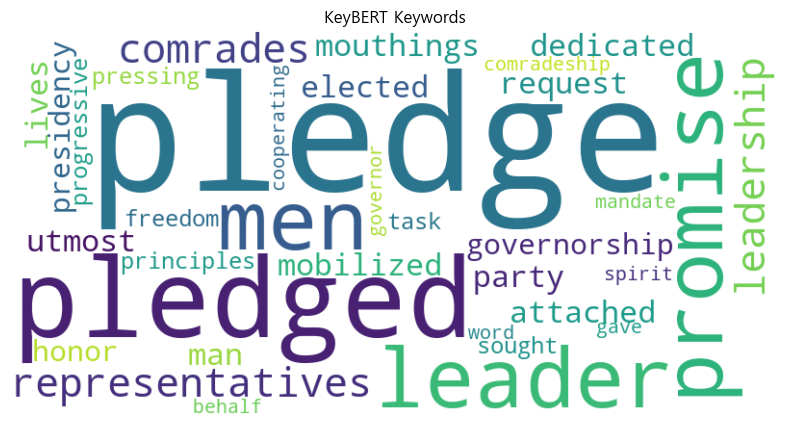

In [171]:
# 워드클라우드로 후보별 키워드 시각화

i = 7

print(df_year_speech_2.loc[i,'Year'], '\n', df_year_speech_2.loc[i,'keybert_year'])

keybert_year_str_2 = df_year_speech_2.loc[i, 'keybert_year']
keybert_year_list_2 = ast.literal_eval(keybert_year_str_2)

# 키워드 추출
keywords = [kw[0] for kw in keybert_year_list_2]

# WordCloud 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))

# WordCloud 표시
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('KeyBERT Keywords')
plt.show()

#### 2) 후보별 연설문 병합

In [113]:
name_speech = defaultdict(str)

for idx, row in df_anal.iterrows():
    name = row['name']
    speech = row['speech_whole']
    name_speech[f'{row["Year"]}_{name}'] += speech

df_name_speech_1 = pd.DataFrame(list(name_speech.items()), columns=['name', 'Speech'])

In [36]:
### 후보별 연설문 keybert

# df_name_speech_1 = df_name_speech_1.sort_values('name')
# keybert_name_speech_1 = kw_model.extract_keywords(df_name_speech_1['Speech'], keyphrase_ngram_range=(1, 2), stop_words='english', top_n=30)
# df_name_speech_1['keybert_name'] = keybert_name_speech_1
# df_name_speech_1.to_csv(r'E:\est\kdt\project\president_prediction\data\candidate_keywords.csv')

In [4]:
df_name_speech_1 = pd.read_csv(r'E:\est\kdt\project\president_prediction\data\candidate_keywords.csv', index_col=0)
df_name_speech_1.head(2)

,name,Speech,keybert_name
0,1916_Charles E. Hughes,Mr. Chairman and Delegates: I have not desired...,"[('chairman delegates', 0.5029), ('desired nom..."
1,1916_Woodrow Wilson,"Senator James, Gentlemen of the Notification C...","[('senator james', 0.4726), ('wish democratic'..."


In [5]:
for i in range(30):
    print(df_name_speech_1['keybert_name'][i])

[('chairman delegates', 0.5029), ('desired nomination', 0.4455), ('delegates desired', 0.4288), ('accept nomination', 0.4271), ('nomination', 0.4201), ('delegates', 0.4198), ('regard mexico', 0.4162), ('nomination wished', 0.413), ('nomination stand', 0.4082), ('congress adequately', 0.4068), ('maintain american', 0.3786), ('powers congress', 0.3767), ('chairman', 0.3687), ('partisan consideration', 0.3673), ('national exigency', 0.3547), ('patriotic realization', 0.3545), ('partisan expediency', 0.3491), ('effort patriotic', 0.348), ('stand americanism', 0.3474), ('congress', 0.3471), ('patriotic', 0.3466), ('constitutional', 0.3404), ('firmly rights', 0.3297), ('national ability', 0.328), ('answer pledge', 0.3259), ('competent', 0.3222), ('going americanism', 0.3167), ('mr chairman', 0.3163), ('use constitutional', 0.3162), ('conception partisan', 0.3155)]
[('senator james', 0.4726), ('wish democratic', 0.4346), ('reaction democrats', 0.4098), ('democratic convention', 0.4076), ('sen

1956_Adlai Stevenson 
 [('congress accomplishments', 0.4246), ('eisenhower administration', 0.4219), ('president administration', 0.4014), ('treasurer legacy', 0.3914), ('democratic administration', 0.3869), ('congress', 0.3848), ('presidency proud', 0.3806), ('eisenhower cynically', 0.3765), ('leadership eisenhower', 0.3755), ('republican administration', 0.3724), ('party respect', 0.3707), ('president words', 0.3639), ('contributed national', 0.3636), ('great campaigner', 0.363), ('president purpose', 0.3623), ('administration democratic', 0.3604), ('graciously president', 0.3589), ('american statesman', 0.3576), ('democratic congress', 0.3571), ('democrats congress', 0.3567), ('conduct president', 0.3564), ('bless partisanship', 0.356), ('eisenhower', 0.3557), ('distinguished guests', 0.3554), ('administration enjoyed', 0.3554), ('vigorous partisan', 0.3552), ('sincerity republican', 0.353), ('grateful convention', 0.3513), ('let administration', 0.3511), ('presidency united', 0.346

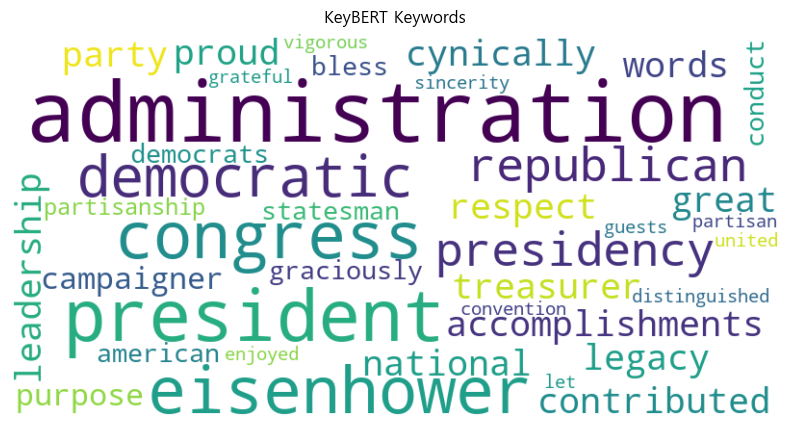

In [102]:
# 워드클라우드로 후보별 키워드 시각화

i = 20

print(df_name_speech_1.loc[i,'name'], '\n', df_name_speech_1.loc[i,'keybert_name'])

keybert_name_str = df_name_speech_1.loc[i, 'keybert_name']
keybert_name_list = ast.literal_eval(keybert_name_str)

# 키워드 추출
keywords = [kw[0] for kw in keybert_name_list]

# WordCloud 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))

# WordCloud 표시
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('KeyBERT Keywords')
plt.show()

- 후보별 문장(idf제거)

In [ ]:
### 후보별 문장(idf제거)을 모을 딕셔너리 생성

name_speech_2 = defaultdict(str)

for idx, row in df_anal.iterrows():
    name = row['name']
    speech = row['whole_remove_idf']
    name_speech_2[f'{row["Year"]}_{name}'] += speech

df_name_speech_2 = pd.DataFrame(list(name_speech_2.items()), columns=['name', 'Speech'])

In [86]:
# ### 후보별 연설문(idf제거) keybert

# kw_model = KeyBERT()
# df_name_speech_2 = df_name_speech_2.sort_values('name')
# keybert_name_speech_2 = kw_model.extract_keywords(df_name_speech_2['Speech'], keyphrase_ngram_range=(1, 2), stop_words='english', top_n=30)
# df_name_speech_2['keybert_name'] = keybert_name_speech_2
# df_name_speech_2.to_csv('candidate_keywords_remove_idf.csv')

In [103]:
df_name_speech_2 = pd.read_csv(r'E:\est\kdt\project\president_prediction\data\candidate_keywords_remove_idf.csv', index_col=0)
df_name_speech_2.head(2)

,name,Speech,keybert_name
0,1916_Charles E. Hughes,Mr Chairman Delegates I desired nomination I w...,"[('patriotic realization', 0.4102), ('nations ..."
1,1916_Woodrow Wilson,James Gentlemen Notification Committee Fellow ...,"[('candidates dictate', 0.4026), ('accept lead..."


1916_Charles E. Hughes 
 [('patriotic realization', 0.4102), ('nations subordinated', 0.3995), ('chairman delegates', 0.3922), ('responsibilities diplomatic', 0.3836), ('stand americanism', 0.3801), ('competent administrative', 0.3765), ('patriotism strength', 0.3748), ('ideals honorable', 0.3743), ('effort patriotic', 0.374), ('honorable', 0.3679), ('thorough americanism', 0.3627), ('delegates desired', 0.3621), ('patriotic', 0.3574), ('partisan expediency', 0.357), ('competent', 0.3563), ('pride honorable', 0.35), ('democracy patriotism', 0.3476), ('nations stand', 0.3411), ('diplomatic', 0.3385), ('firmly rights', 0.3361), ('delegates', 0.3323), ('desire diplomacy', 0.3286), ('honorable peace', 0.328), ('efficiency competent', 0.3257), ('realizing democracy', 0.3201), ('accept nomination', 0.3196), ('purpose patriotism', 0.3191), ('ability command', 0.3183), ('disposition sustain', 0.318), ('command abroad', 0.3164)]


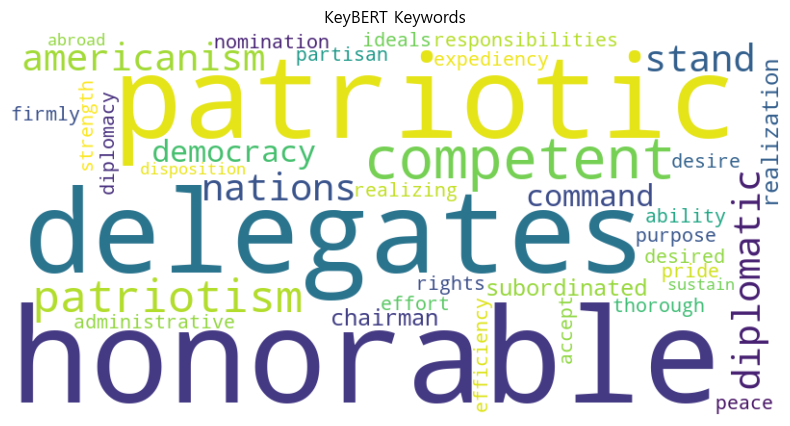

In [104]:
# 워드클라우드로 후보별 키워드 시각화

i = 0

print(df_name_speech_2.loc[i,'name'], '\n', df_name_speech_2.loc[i,'keybert_name'])

keybert_name_str_2 = df_name_speech_2.loc[i, 'keybert_name']
keybert_name_list_2 = ast.literal_eval(keybert_name_str_2)

# 키워드 추출
keywords = [kw[0] for kw in keybert_name_list_2]

# WordCloud 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))

# WordCloud 표시
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('KeyBERT Keywords')
plt.show()

#### 3) 대선 당락별 연설문 병합

In [48]:
# 대선 당락별로 문장을 모을 딕셔너리 생성
elected_speech = defaultdict(str)

for idx, row in df_anal.iterrows():
    elected = int(row['elected'])
    speech = row['whole_remove_idf']
    elected_speech[elected] += speech

df_elected_speech_1 = pd.DataFrame(list(elected_speech.items()), columns=['elected', 'Speech'])

# 연도별 대선 당락 여부로 문장을 모을 딕셔너리 생성
elected_speech = defaultdict(str)

for idx, row in df_anal.iterrows():
    elected = int(row['elected'])
    speech = row['whole_remove_idf']
    elected_speech[f'{row["Year"]}_{elected}'] += speech

df_elected_speech_2 = pd.DataFrame(list(elected_speech.items()), columns=['elected', 'Speech'])

In [ ]:
#### 당락별 연설문 keybert

# kw_model = KeyBERT()
# keybert_name_speech_1 = kw_model.extract_keywords(df_elected_speech_1['Speech'], keyphrase_ngram_range=(1, 2), stop_words='english', top_n=30)
# df_elected_speech_1['keybert_name'] = keybert_name_speech_1
# df_elected_speech_1.to_csv(r'E:\est\kdt\project\president_prediction\data\elected_outcome_keywords.csv')

# kw_model = KeyBERT()
# keybert_elected_speech_2 = kw_model.extract_keywords(df_elected_speech_2['Speech'], keyphrase_ngram_range=(1, 2), stop_words='english', top_n=30)
# df_elected_speech_2['keybert_name'] = keybert_elected_speech_2
# df_elected_speech_2.to_csv(r'E:\est\kdt\project\president_prediction\data\elected_year_outcome_keywords.csv')

In [187]:
df_elected_speech_1 = pd.read_csv(r'E:\est\kdt\project\president_prediction\data\elected_outcome_keywords.csv', index_col=0)
df_elected_speech_2 = pd.read_csv(r'E:\est\kdt\project\president_prediction\data\elected_year_outcome_keywords.csv', index_col=0)

In [188]:
df_elected_speech_1.columns, df_elected_speech_2.columns

(Index(['elected', 'Speech', 'keybert_name'], dtype='object'),
 Index(['elected', 'Speech', 'keybert_name'], dtype='object'))

1 
 [('assured leadership', 0.4656), ('ineptness leadership', 0.4603), ('asserting leadership', 0.4598), ('leadership assertive', 0.4567), ('disillusioned leadership', 0.4563), ('leaders affirm', 0.4512), ('satisfied leadership', 0.4479), ('parties reaffirms', 0.447), ('assertive leadership', 0.447), ('confidence congressman', 0.4469), ('thoughtful leaders', 0.4439), ('leadership assured', 0.4435), ('thoughtful leadership', 0.4423), ('assert leadership', 0.4419), ('prudent leadership', 0.4412), ('leadership satisfied', 0.4409), ('leadership honest', 0.4407), ('promises leaders', 0.4406), ('candidates faithful', 0.4393), ('leadership confident', 0.4375), ('satisfied congressman', 0.4374), ('party honorable', 0.4364), ('obligation democrats', 0.4326), ('assure leadership', 0.4319), ('honest leadership', 0.4298), ('acknowledged leader', 0.4292), ('parties promises', 0.4281), ('unquestioned leadership', 0.428), ('acknowledge leadership', 0.4276), ('candidates promises', 0.4276)]


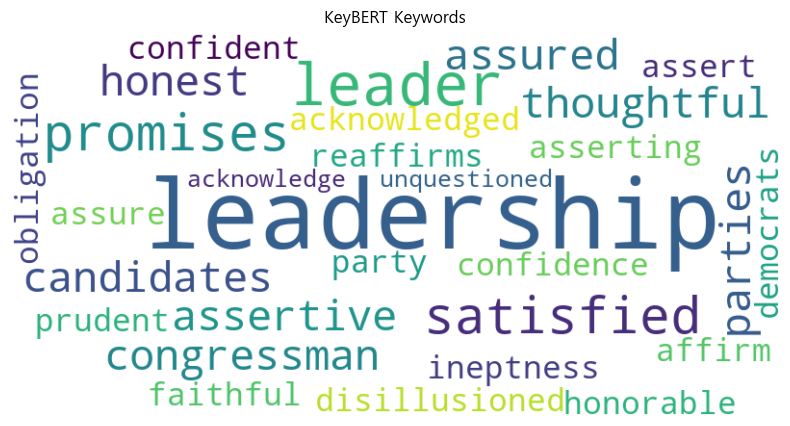

In [189]:
# 워드클라우드로 당락별 키워드 시각화

i = 1

print(df_elected_speech_1.loc[i,'elected'], '\n', df_elected_speech_1.loc[i,'keybert_name'])

keybert_elected_str = df_elected_speech_1.loc[i, 'keybert_name']
keybert_elected_list = ast.literal_eval(keybert_elected_str)

# 키워드 추출
keywords = [kw[0] for kw in keybert_elected_list]

# WordCloud 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))

# WordCloud 표시
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('KeyBERT Keywords')
plt.show()

```
1. 낙선 연설문 인사이트
- 애국심과 리더십: 국가에 대한 헌신과 리더십 자질 강조.
distinguished patriotic, patriotic leadership, honorable patriotic, invoke patriotic, unanimity patriotic, patriotic posturing

- 헌법과 법적 책임: 헌법과 법적 책임의 중요성 강조.
oath preside, uphold sworn, constitution command, received mandate, vigorous mandate, commands allegiance

- 리더십의 능력과 역량: 리더십의 역량과 능력, 외교적 역량 강조.
statesmanship command, statesmanship capable, identify competent, form statesman, patriotism statesmanship, capability diplomatic

- 정당 및 정치적 태도: 정당에 대한 언급과 정치적 태도 강조.
commendation democratic, allegation provide, democracy refrain, abilities congressmen, honorable leaders

- 정치적 경과와 상황: 정치적 입장과 상황 설명
statements patriotic, held statesmanlike, mandate described, recognized mandate, delegates nations


2. 당선 연설문 인사이트
- 리더십의 중요성: 강력하고 다양한 리더십 스타일을 강조.
assured leadership, ineptness leadership, asserting leadership, leadership assertive, disillusioned leadership, satisfied leadership, assertive leadership, leadership assured, thoughtful leadership, prudent leadership, leadership honest, leadership confident, honest leadership, unquestioned leadership, acknowledge leadership
리더십의 여러 측면이 언급되었습니다: assured (확신하는), assertive (단호한), thoughtful (사려 깊은), prudent (신중한), honest (정직한), confident (자신 있는), unquestioned (의심의 여지가 없는).

- 신뢰와 약속: 유권자들에게 신뢰를 주고, 약속을 지키겠다는 메시지.
promises leaders, candidates faithful, promises leadership, candidates promises

- 정당과의 연계: 자신의 리더십뿐만 아니라 소속 정당의 가치를 함께 강조.
parties reaffirms, party honorable, parties promises, obligation democrats

- 확신과 신뢰: 유권자들에게 확신을 주고 신뢰할 수 있는 지도자로서의 이미지 구축.
assured leadership, leadership confident, leadership honest, unquestioned leadership, acknowledge leadership
```

1916_0 
 [('patriotic realization', 0.4102), ('nations subordinated', 0.3995), ('chairman delegates', 0.3922), ('responsibilities diplomatic', 0.3836), ('stand americanism', 0.3801), ('competent administrative', 0.3765), ('patriotism strength', 0.3748), ('ideals honorable', 0.3743), ('effort patriotic', 0.374), ('honorable', 0.3679), ('thorough americanism', 0.3627), ('delegates desired', 0.3621), ('patriotic', 0.3574), ('partisan expediency', 0.357), ('competent', 0.3563), ('pride honorable', 0.35), ('democracy patriotism', 0.3476), ('nations stand', 0.3411), ('diplomatic', 0.3385), ('firmly rights', 0.3361), ('delegates', 0.3323), ('desire diplomacy', 0.3286), ('honorable peace', 0.328), ('efficiency competent', 0.3257), ('realizing democracy', 0.3201), ('accept nomination', 0.3196), ('purpose patriotism', 0.3191), ('ability command', 0.3183), ('disposition sustain', 0.318), ('command abroad', 0.3164)]


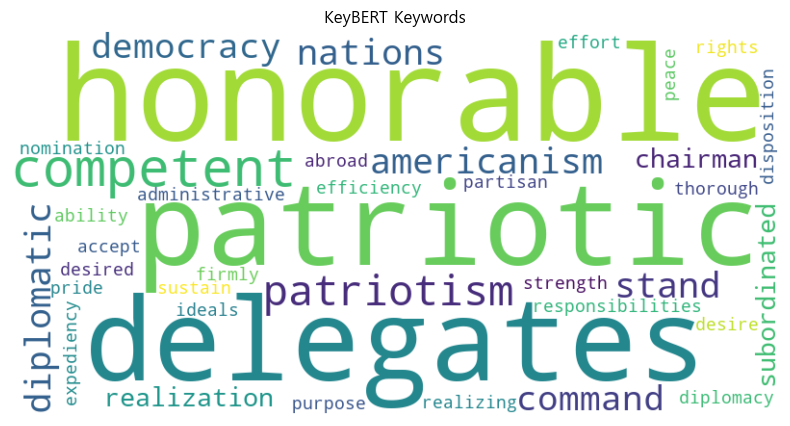

In [108]:
# 워드클라우드로 당락 연도별 키워드 시각화

i = 0

print(df_elected_speech_2.loc[i,'elected'], '\n', df_elected_speech_2.loc[i,'keybert_name'])

keybert_elected_str_2 = df_elected_speech_2.loc[i, 'keybert_name']
keybert_elected_list_2 = ast.literal_eval(keybert_elected_str_2)

# 키워드 추출
keywords = [kw[0] for kw in keybert_elected_list_2]

# WordCloud 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))

# WordCloud 표시
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('KeyBERT Keywords')
plt.show()

#### 3) 정당별 연설문 병합

In [52]:
df_anal.columns

Index(['name', 'date', 'elected', 'Year', 'speech_whole', 'speech_processed',
       'speech_processed2', 'Party', 'Elections_Won', 'whole_remove_idf'],
      dtype='object')

In [59]:
# 정당별로 문장을 모을 딕셔너리 생성
party_speech_1 = defaultdict(str)

for idx, row in df_anal.iterrows():
    party = row['Party']
    speech = row['whole_remove_idf']
    party_speech_1[party] += speech

df_party_speech_1 = pd.DataFrame(list(party_speech_1.items()), columns=['Party', 'Speech'])

# 연도별 대선 당락 여부로 문장을 모을 딕셔너리 생성
party_speech_2 = defaultdict(str)

for idx, row in df_anal.iterrows():
    party = row['Party']
    speech = row['whole_remove_idf']
    party_speech_2[f'{row["Year"]}_{party}'] += speech

df_party_speech_2 = pd.DataFrame(list(party_speech_2.items()), columns=['Party', 'Speech'])
df_party_speech_2.sort_values('Party', inplace=True)

In [62]:
df_party_speech_1

,Party,Speech
0,Republican,Mr Chairman Delegates I desired nomination I w...
1,Democratic,James Gentlemen Notification Committee Fellow ...


In [66]:
df_party_speech_2.head(2)

,Party,Speech
1,1916_Democratic,James Gentlemen Notification Committee Fellow ...
0,1916_Republican,Mr Chairman Delegates I desired nomination I w...


In [ ]:
# ### 정당별 연설문 keybert

# kw_model = KeyBERT()
# keybert_party_speech_1 = kw_model.extract_keywords(df_party_speech_1['Speech'], keyphrase_ngram_range=(1, 2), stop_words='english', top_n=30)
# df_party_speech_1['keybert_name'] = keybert_party_speech_1
# df_party_speech_1.to_csv('party_keywords.csv')

# kw_model = KeyBERT()
# keybert_party_speech_2 = kw_model.extract_keywords(df_party_speech_2['Speech'], keyphrase_ngram_range=(1, 2), stop_words='english', top_n=30)
# df_party_speech_2['keybert_name'] = keybert_party_speech_2
# df_party_speech_2.to_csv('party_year_keywords.csv')

In [190]:
df_party_speech_1 = pd.read_csv(r'E:\est\kdt\project\president_prediction\data\party_keywords.csv')
df_party_speech_2 = pd.read_csv(r'E:\est\kdt\project\president_prediction\data\party_year_keywords.csv')

Democratic 
 [('assured leadership', 0.4656), ('sincerity republican', 0.461), ('asserting leadership', 0.4598), ('leadership assertive', 0.4567), ('disillusioned leadership', 0.4563), ('leaders affirm', 0.4512), ('satisfied leadership', 0.4479), ('parties reaffirms', 0.447), ('assertive leadership', 0.447), ('confidence congressman', 0.4469), ('thoughtful leaders', 0.4439), ('leadership assured', 0.4435), ('thoughtful leadership', 0.4423), ('assert leadership', 0.4419), ('confidence democrats', 0.4415), ('prudent leadership', 0.4412), ('leadership satisfied', 0.4409), ('leadership honest', 0.4407), ('promises leaders', 0.4406), ('candidates faithful', 0.4393), ('confident leadership', 0.4378), ('leadership confident', 0.4375), ('satisfied congressman', 0.4374), ('party honorable', 0.4364), ('obligation democrats', 0.4326), ('assure leadership', 0.4319), ('honest leadership', 0.4298), ('doubt leadership', 0.4297), ('parties promises', 0.4281), ('unquestioned leadership', 0.428)]


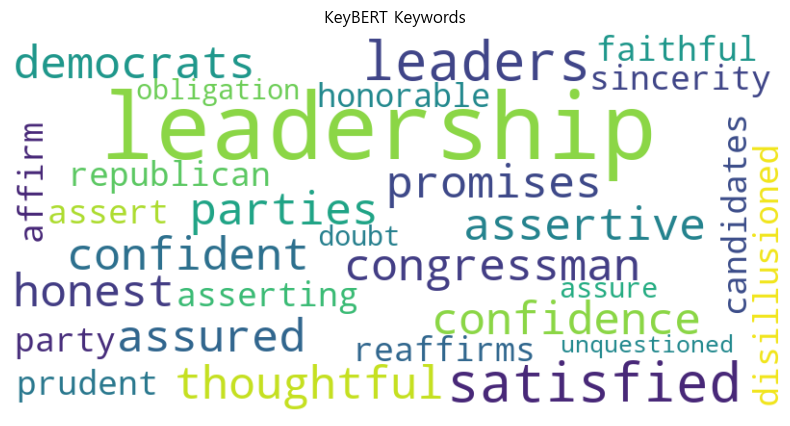

In [192]:
# 워드클라우드로 정당별 키워드 시각화

i = 1

print(df_party_speech_1.loc[i,'Party'], '\n', df_party_speech_1.loc[i,'keybert_name'])

keybert_party_str = df_party_speech_1.loc[i, 'keybert_name']
keybert_party_list = ast.literal_eval(keybert_party_str)

# 키워드 추출
keywords = [kw[0] for kw in keybert_party_list]

# WordCloud 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))

# WordCloud 표시
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('KeyBERT Keywords')
plt.show()

In [ ]:
[('assured leadership', 0.4656), 
('sincerity republican', 0.461), 
('asserting leadership', 0.4598),
('leadership assertive', 0.4567),
('disillusioned leadership', 0.4563),
('leaders affirm', 0.4512),
('satisfied leadership', 0.4479),
('parties reaffirms', 0.447),
('assertive leadership', 0.447),
('confidence congressman', 0.4469),
('thoughtful leaders', 0.4439), 
('leadership assured', 0.4435),
('thoughtful leadership', 0.4423), 
('assert leadership', 0.4419), 
('confidence democrats', 0.4415), 
('prudent leadership', 0.4412),
('leadership satisfied', 0.4409),
('leadership honest', 0.4407),
('promises leaders', 0.4406),
('candidates faithful', 0.4393),
('confident leadership', 0.4378), 
('leadership confident', 0.4375),               
('satisfied congressman', 0.4374),
('party honorable', 0.4364),
('obligation democrats', 0.4326), 
('assure leadership', 0.4319), 
('honest leadership', 0.4298), 
('doubt leadership', 0.4297), 
('parties promises', 0.4281),
('unquestioned leadership', 0.428)]


```
1. 공화당의 역대 연설문에서 주요하게 다뤄진 주제
- 애국심과 리더십: 애국적 언어와 리더십 자질의 강조.
distinguished patriotic, patriotic leadership, honorable patriotic, statements patriotic, unanimity patriotic, patriotic posturing, aligned patriotic.

- 헌법과 법적 책임: 헌법과 법적 책임에 대한 충실성.
oath preside, uphold sworn, received mandate, duty statesmanship, mandate described, vigorous mandate

- 리더십의 능력과 정직성: 리더십의 역량과 도덕적 기준.
competent principled, statesmanship capable, rectitude statesmanship, honorable leaders, capability diplomatic.

- 정당의 명성 및 단합: 정당의 명성과 내부 단합 강조.
honorable form, delegation pleased, honorable leaders, delegates nations

- 전략적 언급과 외교적 역할: 외교적 역량과 시민 동원.
capability diplomatic, mobilization citizen, patriotism capable, statesmanship adhere


2. 민주당의 역대 연설문에서 강조된 주요 주제
- 리더십의 강조: 리더십의 확신과 능력 강조, 다양한 리더십 스타일을 부각.
assured leadership, asserting leadership, leadership assertive, disillusioned leadership, satisfied leadership, assertive leadership, leadership assured, thoughtful leadership, prudent leadership, confident leadership, honest leadership, unquestioned leadership

- 정당의 명성과 약속: 정당의 신뢰성과 약속을 지키려는 강조.
sincerity republican, parties reaffirms, parties promises, promises leaders, candidates faithful, obligation democrats, party honorable

- 리더십의 다양한 측면: 사려 깊고 신중하며 정직한 리더십 강조.
thoughtful leaders, prudent leadership, leadership honest, leadership satisfied, doubt leadership

- 정당 간의 비교와 차별화: 공화당과의 차별화를 통한 민주당의 신뢰성과 진정성 강조.
sincerity republican, confidence democrats, obligation democrats

- 리더십의 신뢰와 약속: 리더십의 신뢰성과 약속을 강조하며 유권자에게 확신 제공.
promises leaders, candidates faithful, leadership confident, unquestioned leadership, honest leadership
```

1916_Democratic 
 [('statesmanship', 0.3828), ('authority republic', 0.3737), ('sovereign authority', 0.3716), ('republics distrusted', 0.3674), ('respect sovereignty', 0.3671), ('constituted power', 0.3643), ('candidates dictate', 0.3623), ('sovereignty await', 0.3601), ('international affairs', 0.3595), ('served traitorously', 0.3549), ('sovereignty weaker', 0.3547), ('dealings nations', 0.348), ('violations sovereignty', 0.3362), ('necessary nations', 0.3353), ('restoration sworn', 0.3345), ('statesmanship loses', 0.3344), ('violation sovereignty', 0.3343), ('citizen seek', 0.3334), ('governed international', 0.3318), ('sovereignty', 0.3301), ('sovereignty wait', 0.3292), ('responsibility democratic', 0.3278), ('committee fellow', 0.3265), ('traitorously overthrew', 0.3255), ('republic treachery', 0.3223), ('authority organization', 0.3207), ('dictated privileges', 0.3189), ('threatened imperilled', 0.3165), ('conduct shall', 0.3159), ('stood democratic', 0.3158)]


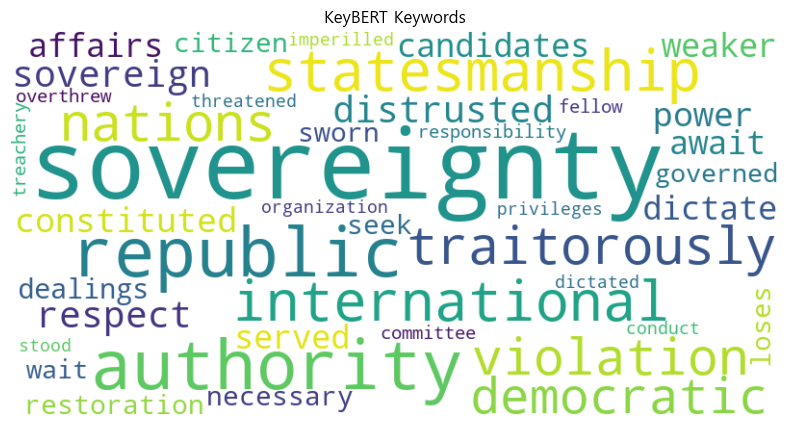

In [111]:
# 워드클라우드로 당락 연도별 키워드 시각화

i = 0

print(df_party_speech_2.loc[i,'Party'], '\n', df_party_speech_2.loc[i,'keybert_name'])

keybert_party_str_2 = df_party_speech_2.loc[i, 'keybert_name']
keybert_party_list_2 = ast.literal_eval(keybert_party_str_2)

# 키워드 추출
keywords = [kw[0] for kw in keybert_party_list_2]

# WordCloud 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))

# WordCloud 표시
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('KeyBERT Keywords')
plt.show()

In [ ]:
## 바뀐데이터로 인물별/시대별 키워드 한번 더 찾아볼것
## 시대별 워드클라우딩할것
## 인물별 키워드 뽑은 것 클러스터링 한 다음에 묶어서 보고 인물이 중요하게 생각했던 키워드 확인 + 워드클라우드
## 당락별 키워드 뽑고, 클러스터링해서 당락에 무엇이 중요한 키워드들인지 확인 + 워드클라우드 ---------------------
## 정당별 키워드 뽑고, 클러스터링해서 정당이 무엇을 중요하게 생각하는 키워드 확인 + 워드클라우드 ---------------------
## 처리하지 않은 전체 연설문에서 idf값 확인해서 낮은 값들 제거 아래에 과정 적어놓음